In [1]:
# Necessary imports
import nltk, re, pandas as pd, xml, os, sklearn, string, numpy as np, time, pickle, gc as gc, warnings
import seaborn as sns, matplotlib.pyplot as plt, plotly.express as px, plotly.offline as plotly_offline
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from nltk.stem.snowball import SnowballStemmer

# Other settings
gc.enable()
warnings.filterwarnings("ignore")
plotly_offline.init_notebook_mode(connected = True)

In [2]:
# Function to parse the xml the Amazon reviews come in
def parse_xml(filepath):    
    # Open the file
    with open(filepath) as file:
        # Read the text
        txt = file.read()
        # Parse the XML for all of the ratings (target)
        ratings = [a.string.strip('\n') for a in BeautifulSoup(txt).find_all('rating')]        
        # Parse the XML for all of the text
        txts = [x.string.strip('\n') for x in BeautifulSoup(txt).find_all('review_text')]
    
    # Return a list of ratings and texts (associated)
    return ratings, txts

# Function to return all folder hierarchies for a given parent
def fast_scandir(dirname):
    # First, get all directories inside the parent directory
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    # Then loop through those, and keep expanding down until there are no more directories
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    # Return total list
    return subfolders

# This function removes numbers from an array
def remove_nums(arr): 
    # Declare a regular expression
    pattern = '[0-9]'  
    # Remove the pattern, which is a number
    arr = [re.sub(pattern, '', i) for i in arr]    
    # Return the array with numbers removed
    return arr

# This function cleans the passed in paragraph and parses it
def get_words(para, stem):   
    # Create a set of stop words
    stop_words = set(stopwords.words('english'))
    # Split it into lower case    
    lower = para.lower().split()
    # Remove punctuation
    no_punctuation = (nopunc.translate(str.maketrans('', '', string.punctuation)) for nopunc in lower)
    # Remove integers
    no_integers = remove_nums(no_punctuation)
    # Remove stop words
    dirty_tokens = (data for data in no_integers if data not in stop_words)
    # Ensure it is not empty
    tokens = [data for data in dirty_tokens if data.strip()]
    # Ensure there is more than 1 character to make up the word
    tokens = [data for data in tokens if len(data) > 1]
       
    if stem == True:
        # Perform stemming
        stemmer = SnowballStemmer('english')
        stemmed_tokens = [stemmer.stem(word) for word in tokens]
        return stemmed_tokens
    
    else:
        # Return the tokens
        return tokens  
    
# Function to plot the distributions of each word in the df
def plot_df_distributions(df, name):
    # Loop through the df
    for col in df.columns:
        # Create a temp numpy array
        temp = df[col].to_numpy()
        # Plot the distribution
        n, bins, patches = plt.hist(temp, bins=3)
        # Set the title
        plt.suptitle("Data Type: {} | {} Distribution".format(str(name), str(col)))
        # Show the figure
        plt.show()    
        
# Function to plot the distributions of each word in the df
def plot_pos_distributions(df, cols):
    # Loop through the df
    for col in cols:
        # Create a temp numpy array
        temp = df[col].to_numpy()
        # Plot the distribution
        n, bins, patches = plt.hist(temp, bins=10)
        # Set the title
        plt.suptitle("POS Tag: {} | Distribution".format(str(col)))
        # Show the figure
        plt.show()        

# Function to plot the results of the classifiers
def plot_results(df, name, metric):
    # Create a plotly figure, and plot whichever metric (best, worst, average) is passed
    fig = px.line(df, x='Simulation', y=metric, color='Classifier')
    # Update title/labels
    fig.update_layout(title='{} Data Classifier Performance'.format(name), xaxis_title='Simulation',
                             yaxis_title='Accuracy')
    # Display the figure
    fig.show()     
    
    
# This function parses NLTK returned POS tuples
def parse_tuples(list_of_tuples, verbose):
    
    # Declare POS counts
    cnt_noun = 0
    cnt_adj = 0
    cnt_vb = 0
    cnt_other = 0
    
    # Loop through the returned tuples
    for tpl in list_of_tuples:
        
        # NOTE - If needed, verbose printing is available to
        # check for completeness.
        
        # If the word is a noun, increase the noun count
        if('NN' in tpl[1]):
            cnt_noun += 1
            if(verbose):
                print("Noun: {}".format(tpl))
        # If the word is an adjective, increase the adjective count
        elif('JJ' in tpl[1]):
            cnt_adj += 1
            if(verbose):
                print("Adjective: {}".format(tpl))
        # If the word is a verb, increase the verb count
        elif('VB' in tpl[1] or 'VP' in tpl[1]):
            cnt_vb += 1
            if(verbose):
                print("Verb: {}".format(tpl))
        # If the word isn't one of those 3, increase the other count
        else:
            cnt_other += 1
            if(verbose):
                print("Other: {}".format(tpl))
    
    # Return the counts
    return cnt_noun, cnt_adj, cnt_vb, cnt_other    

### Step 1 - Parse the Amazon data to create a dataframe

In [5]:
total_df = pd.read_csv('Amazon Reviews.csv')

In [6]:
print(list(set(total_df['Rating'])))

[1.0, 2.0, 4.0, 5.0]


In [11]:
# Create a corpus from the text of the df
s = pd.Series(total_df['Text'].astype('str'))
corpus = s.apply(lambda s: ' '.join(get_words(s, True)))

In [12]:
# Extract the classes
classes = total_df['Rating']

In [13]:
# Determine the minimum # of reviews a word must be in to appear in the vector
# Selected 5%
min_df = int(0.05 * total_df.shape[0])
print(min_df)

1721


In [14]:
# Create vectorizers, and vectors, for the three types of vectors we have described:
# - Frequency, Boolean, and TFIDF
# With the conditions we have described
# - At least 5% of all reviews, no more than 99% of all reviews
trimmed_boolean_vectorizer = CountVectorizer(strip_accents='unicode',
                                             min_df=int(0.05 * total_df.shape[0]), max_df = 0.99, 
                                             binary=True)
trimmed_tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', min_df=int(0.05 * total_df.shape[0]), max_df = 0.99)
trimmed_count_vectorizer = CountVectorizer(strip_accents='unicode', min_df=int(0.05 * total_df.shape[0]), max_df = 0.99)

# Create the vectors
trimmed_tfidf = trimmed_tfidf_vectorizer.fit_transform(corpus)
trimmed_count = trimmed_count_vectorizer.fit_transform(corpus)
trimmed_boolean = trimmed_boolean_vectorizer.fit_transform(corpus)

# Free up some memory
gc.collect()

0

In [15]:
# Now, apply each of these vectorizers to the data and create dataframes
gc.collect()

# Create the dataframes
trimmed_boolean_df = pd.DataFrame(data = trimmed_boolean.todense(), columns = trimmed_boolean_vectorizer.get_feature_names())
trimmed_tfidf_df = pd.DataFrame(data = trimmed_tfidf.todense(), columns = trimmed_tfidf_vectorizer.get_feature_names())
trimmed_count_df = pd.DataFrame(data = trimmed_count.todense(), columns = trimmed_count_vectorizer.get_feature_names())

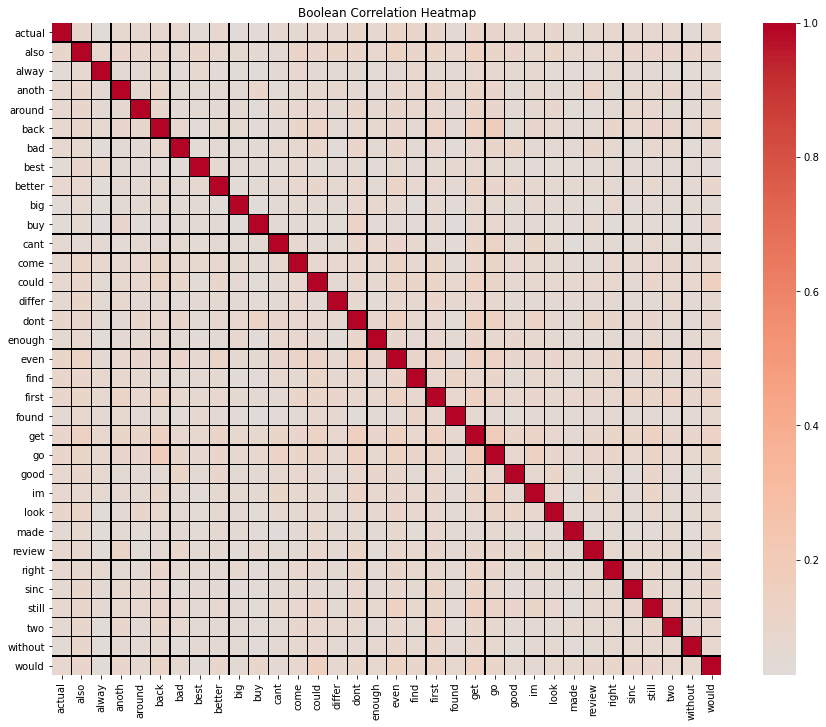

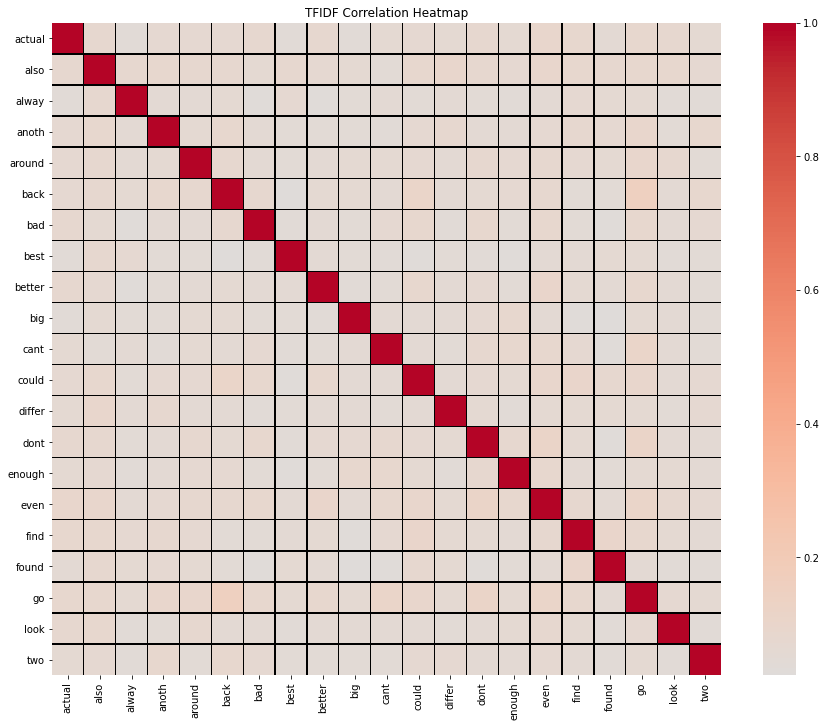

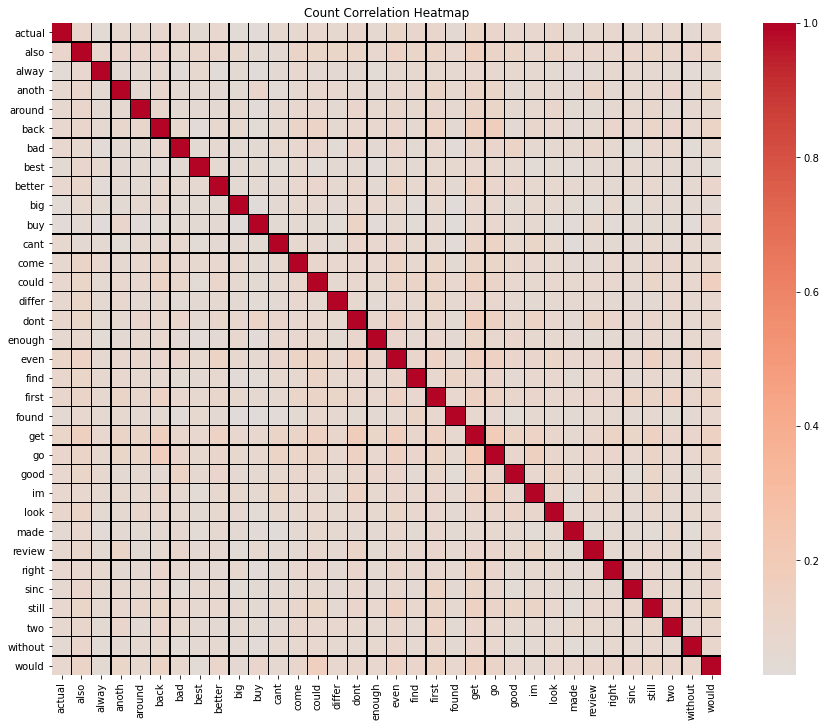

In [16]:
# Create lists of the different dataframes and their names
dfs = [trimmed_boolean_df, trimmed_tfidf_df, trimmed_count_df]
names = ["Boolean", "TFIDF", "Count"]

# Start calculating their correlation

## TODO: Turn this into a function

for i in range(len(dfs)):
    # Set figure and axis size
    fig, ax = plt.subplots(figsize = (15,12))
    # Create a temp copy of the df
    temp = dfs[i].copy()
    # https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
    # Create a correlation matrix
    corr_matrix = temp.corr(method='spearman').abs()
    
    # Do some cleaning to remove features that have more than a 95% correlation, or a less trhan 1% correlation
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95) or any(upper[column] < 0.01)]
    temp.drop(to_drop, axis=1, inplace=True)
    
    # Now, re calculate the correlation with good columns
    corr = temp.corr(method='spearman')
    
    # Create a heatmap
    _ = sns.heatmap(corr, fmt="f", linewidths=0.25, center=0, cmap='coolwarm', linecolor='black')
    # Set the title
    ax.set_title('{} Correlation Heatmap'.format(names[i]))
    
    # Show the plot, then close it
    plt.show()
    plt.close()

In [17]:
# Basic statistics of each dataframe

# Loop through each df
for i in range(len(dfs)):
    # Use pandas describe function
    print("Evaluating: {}".format(names[i]))
    print(dfs[i].describe())
    print("*--------------------------------------------*")
    gc.collect()

Evaluating: Boolean
             actual          also         alway        amazon         anoth  \
count  34436.000000  34436.000000  34436.000000  34436.000000  34436.000000   
mean       0.061593      0.153067      0.053752      0.053432      0.074805   
std        0.240417      0.360057      0.225531      0.224898      0.263081   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             around          back           bad          best        better  \
count  34436.000000  34436.000000  34436.000000  34436.000000  34436.000000   
mean       0.061912      0.108230      0.060721      0.097659      0.117087   
std        0.240999      0.3106

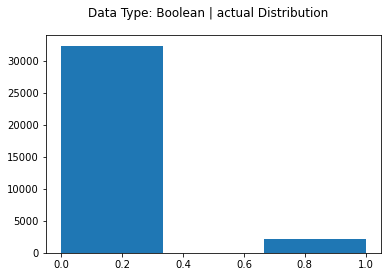

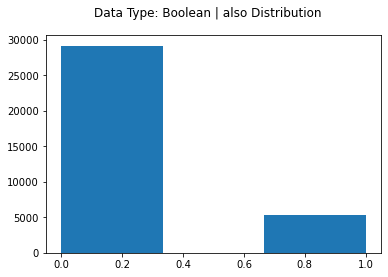

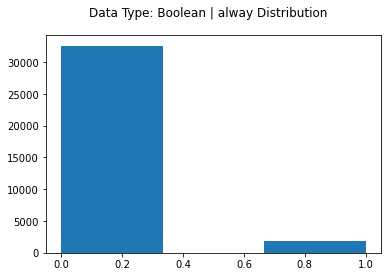

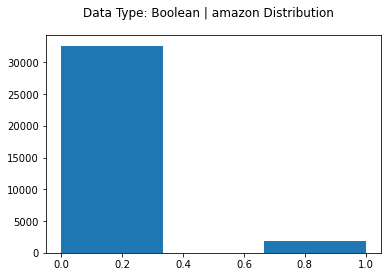

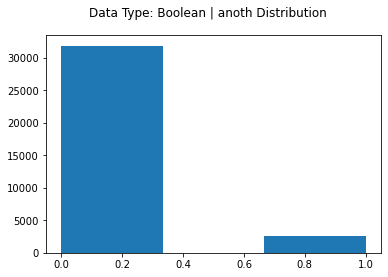

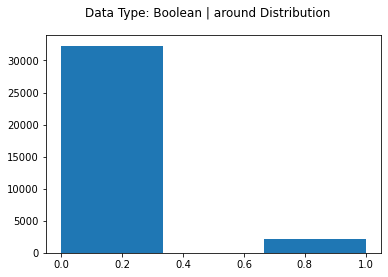

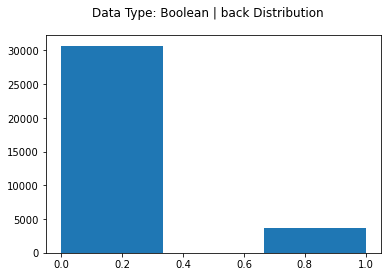

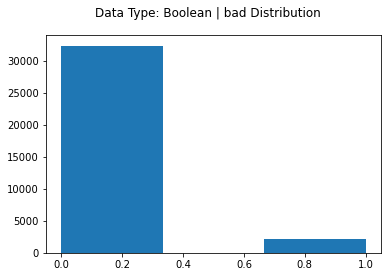

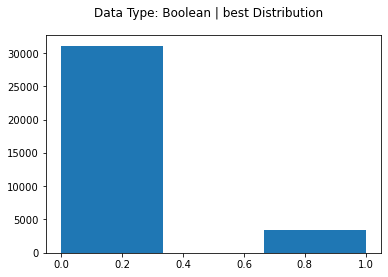

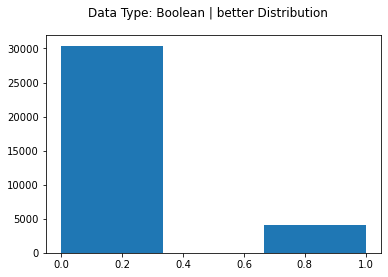

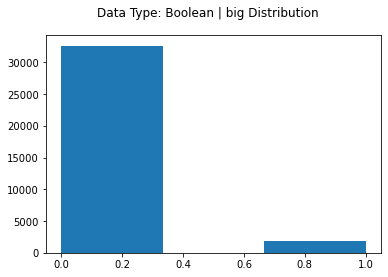

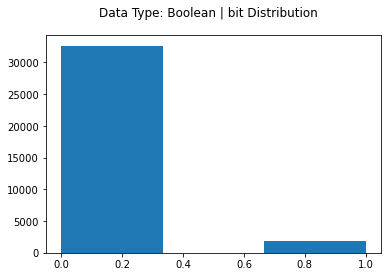

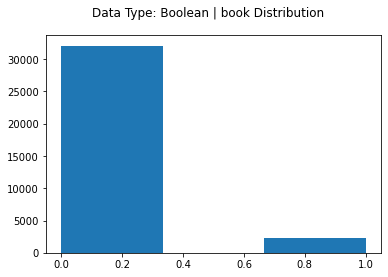

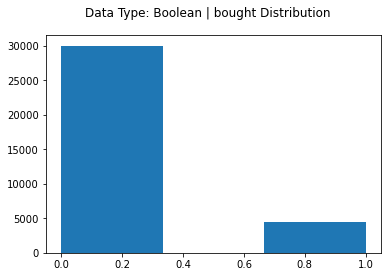

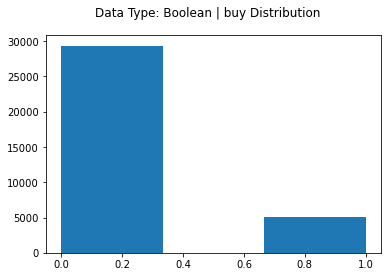

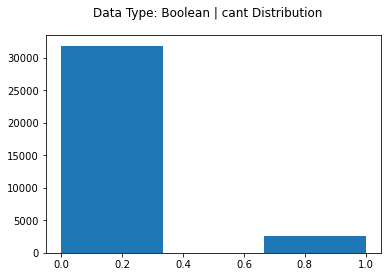

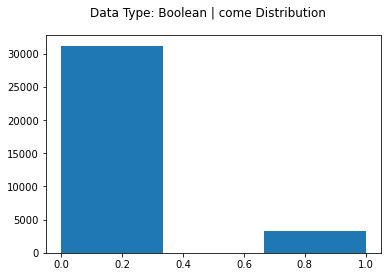

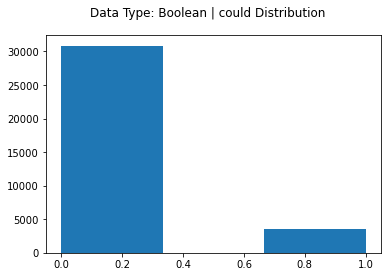

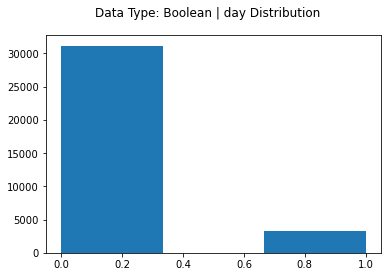

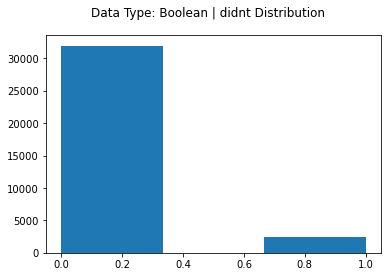

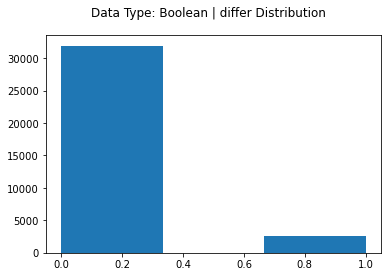

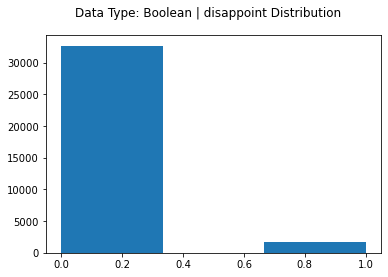

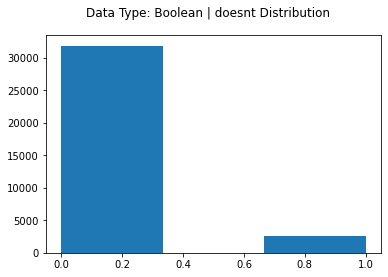

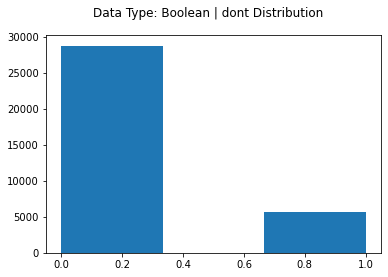

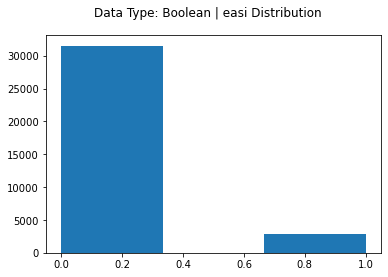

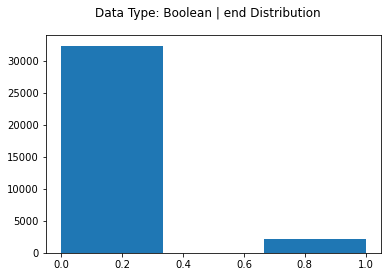

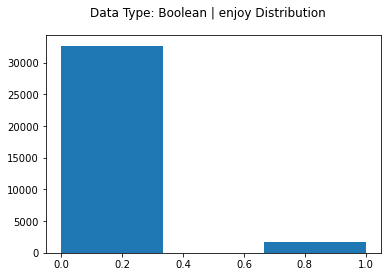

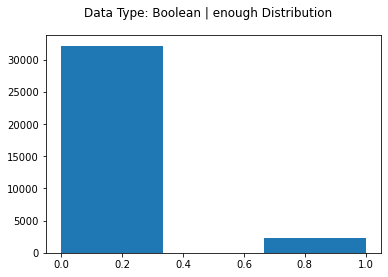

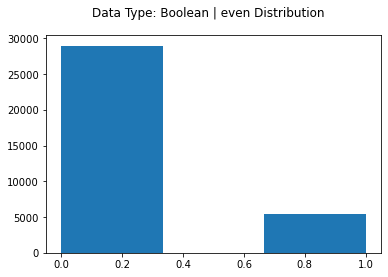

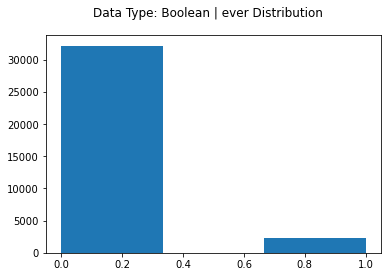

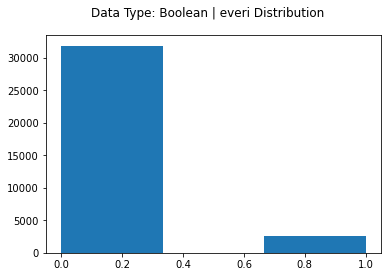

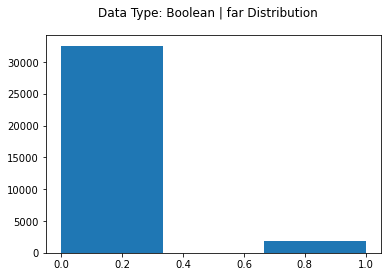

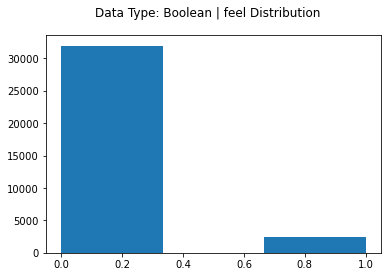

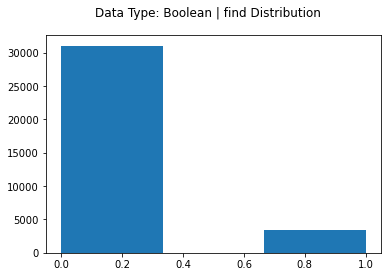

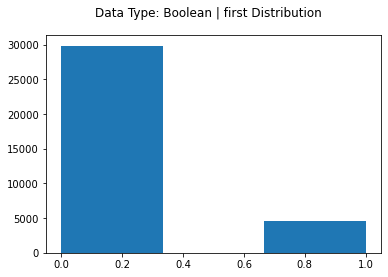

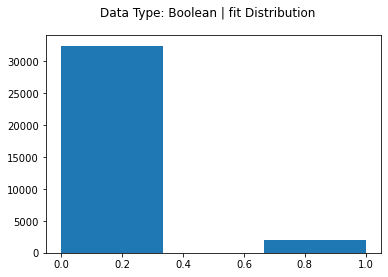

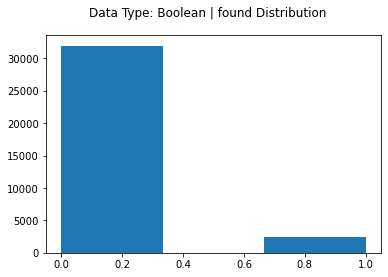

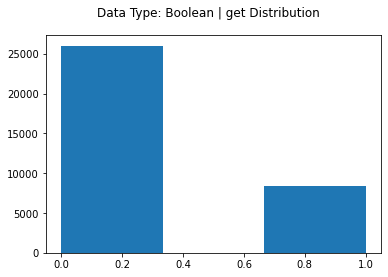

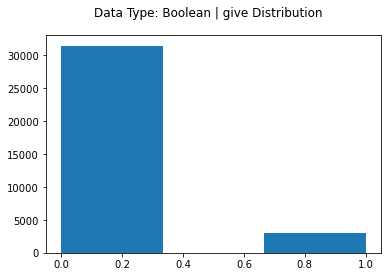

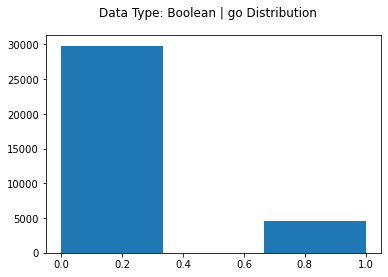

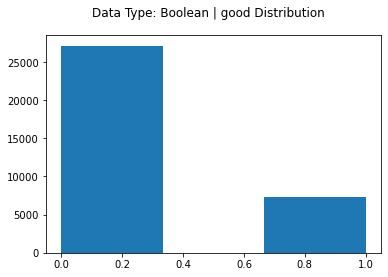

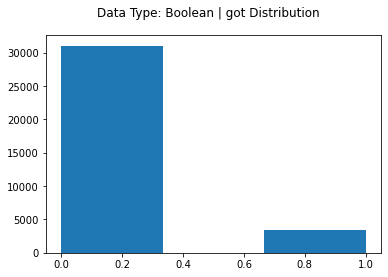

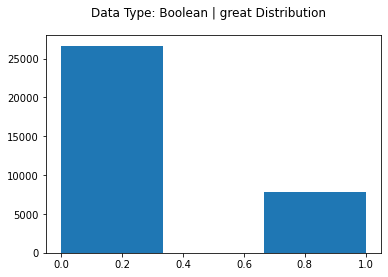

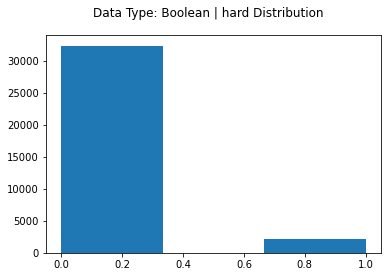

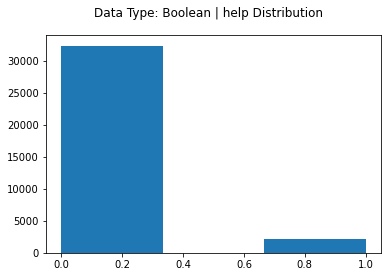

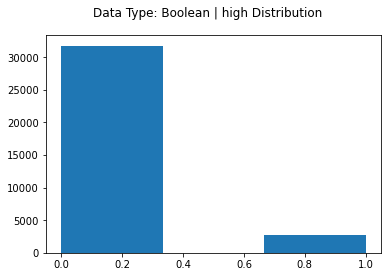

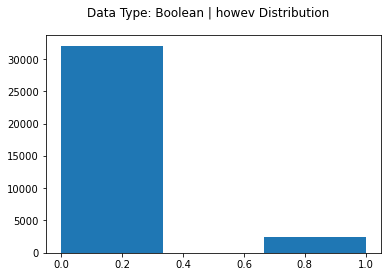

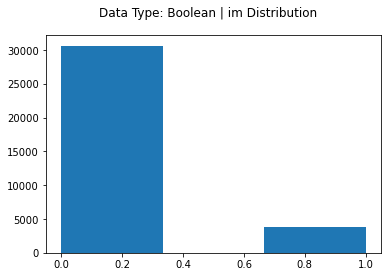

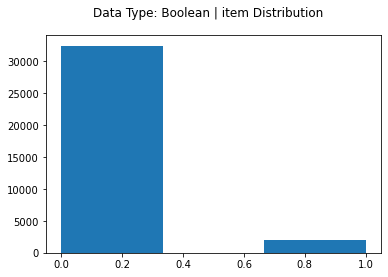

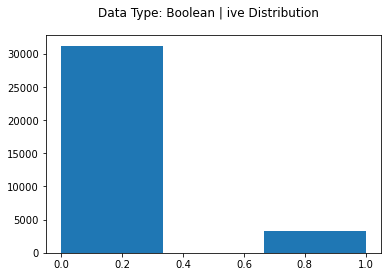

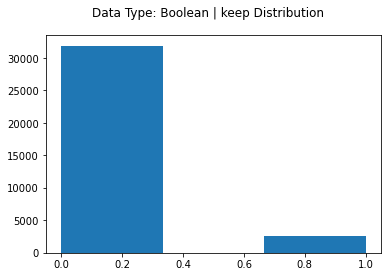

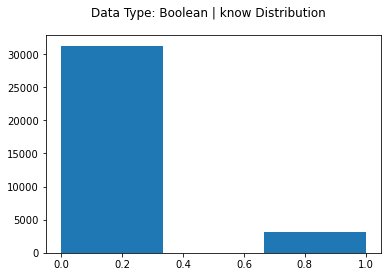

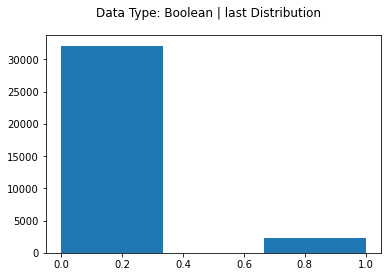

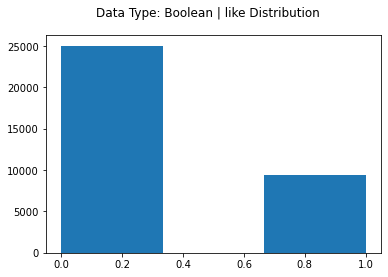

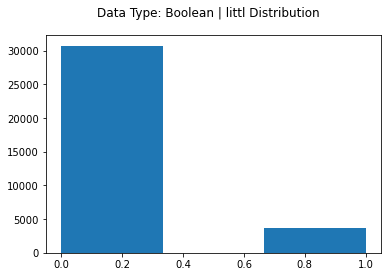

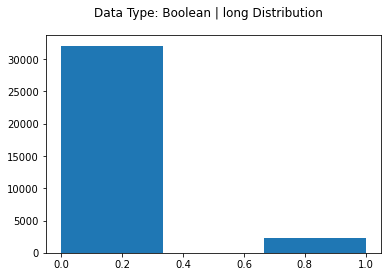

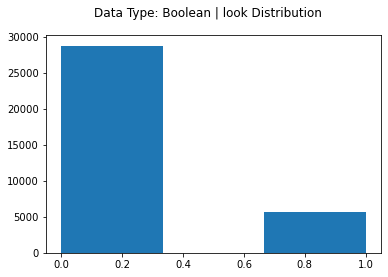

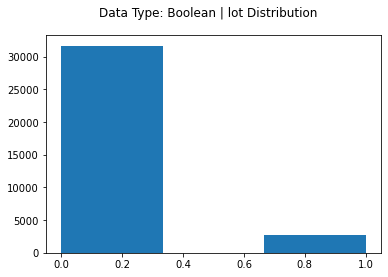

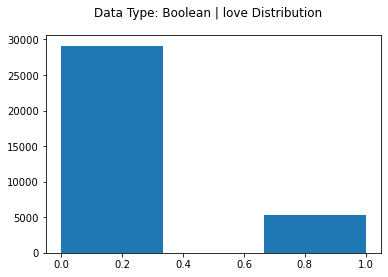

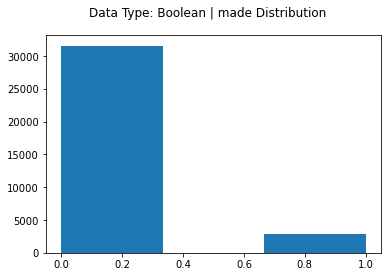

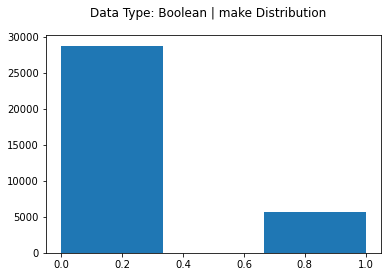

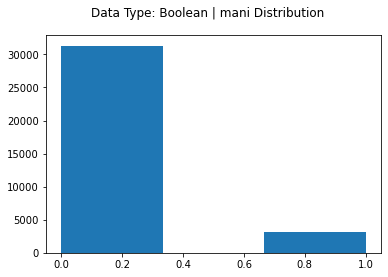

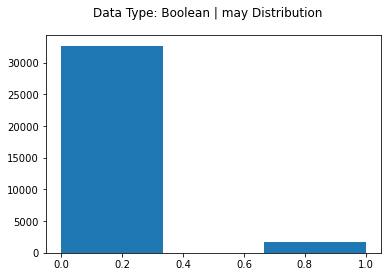

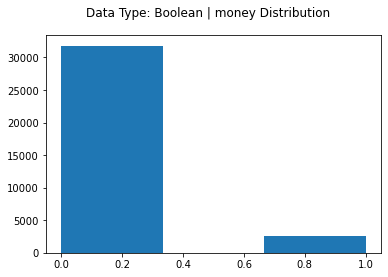

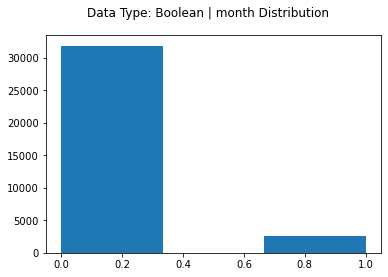

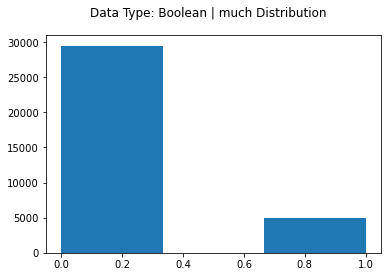

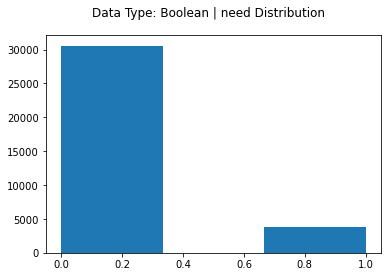

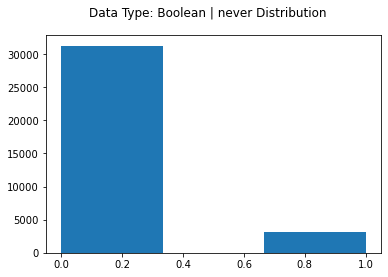

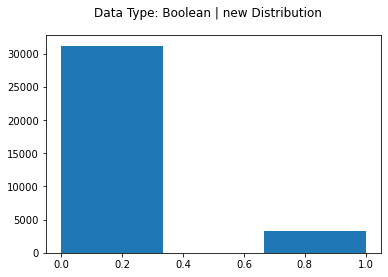

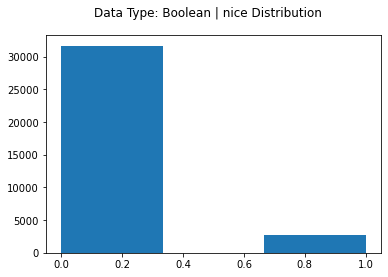

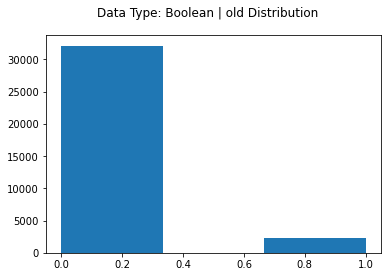

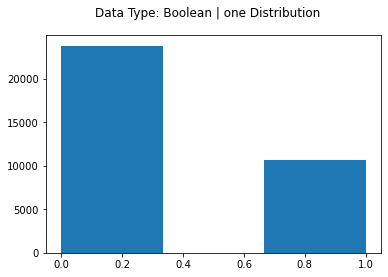

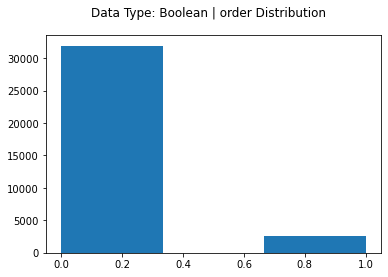

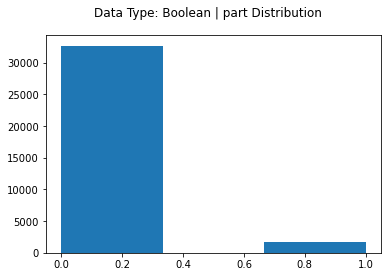

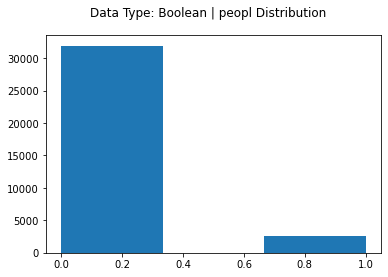

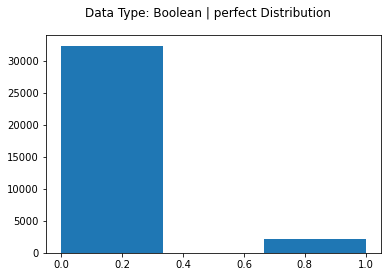

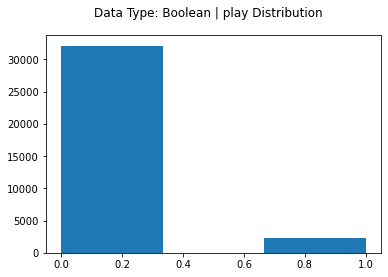

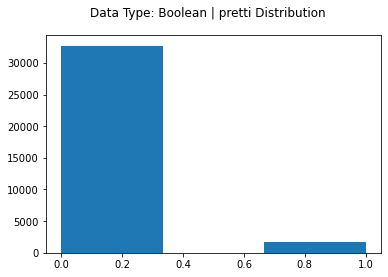

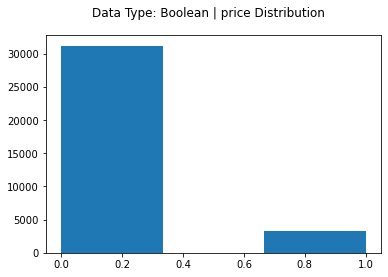

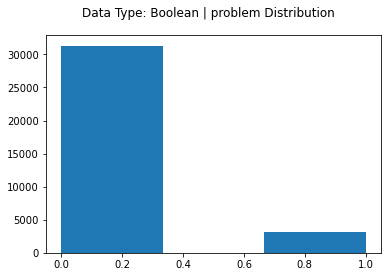

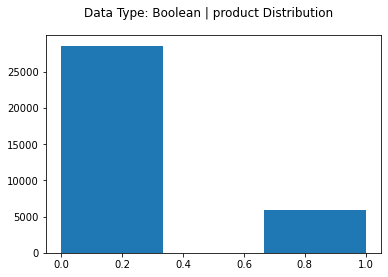

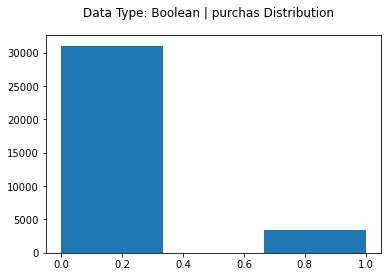

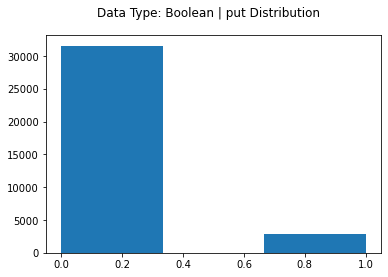

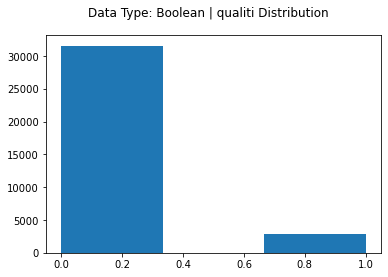

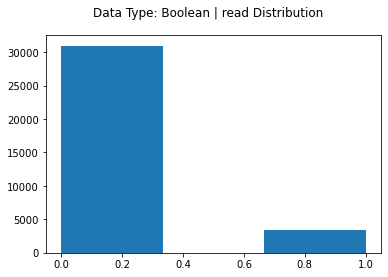

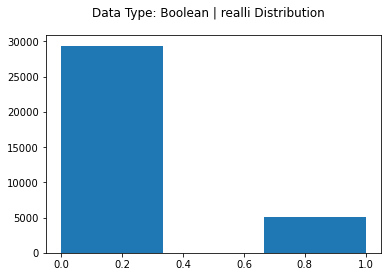

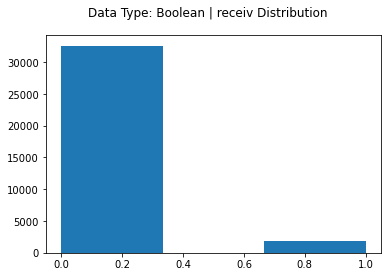

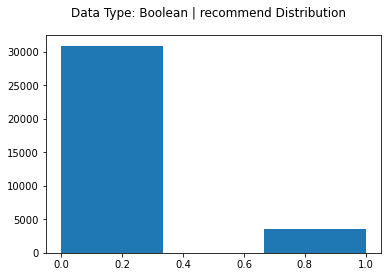

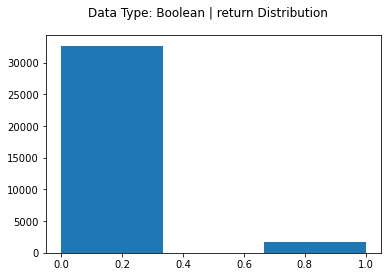

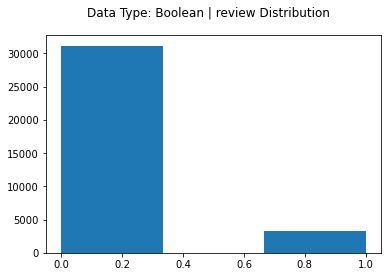

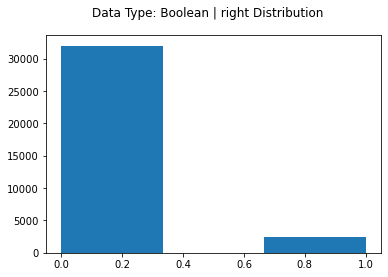

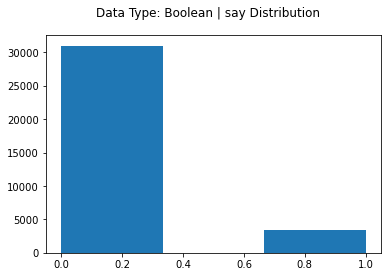

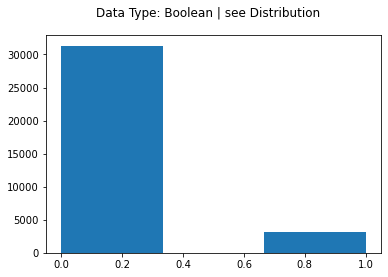

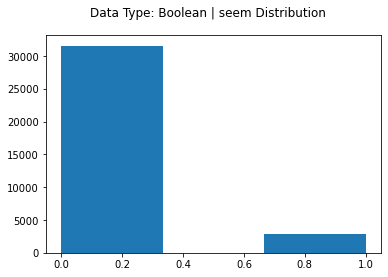

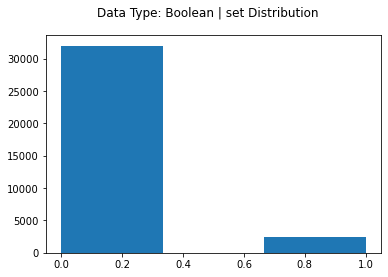

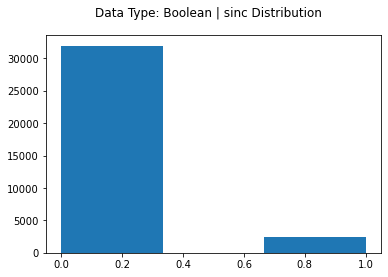

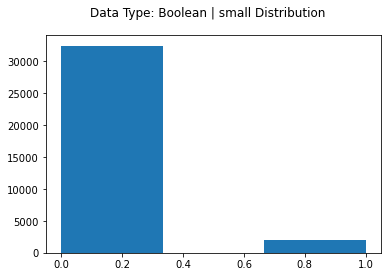

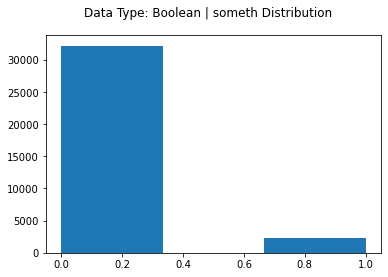

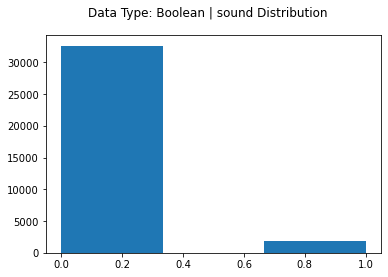

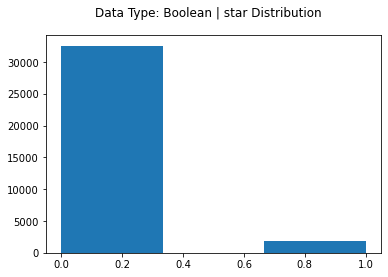

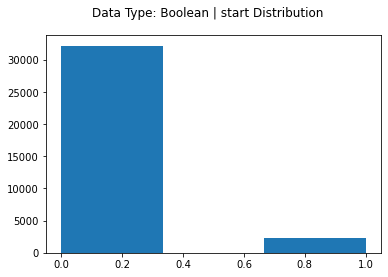

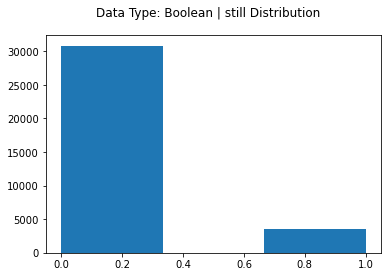

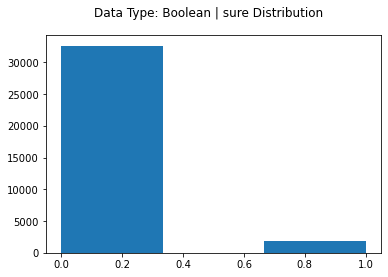

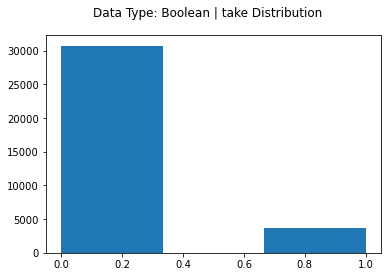

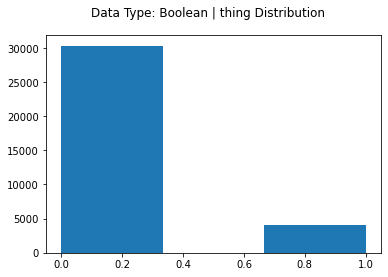

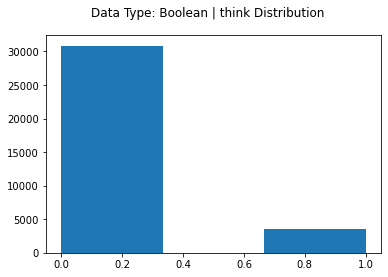

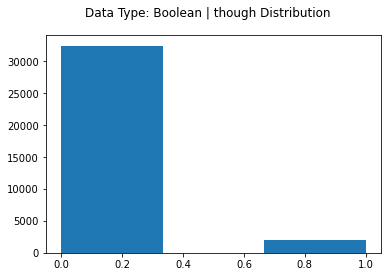

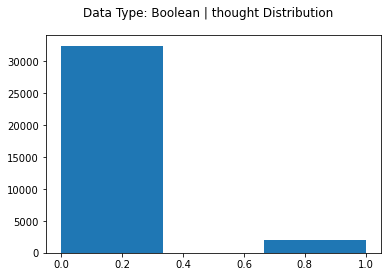

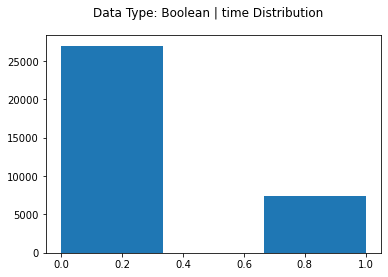

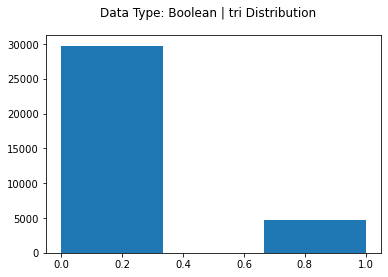

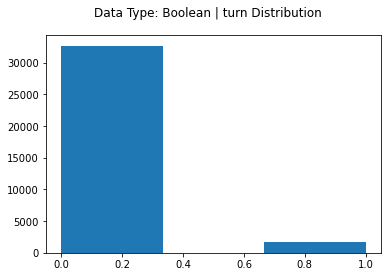

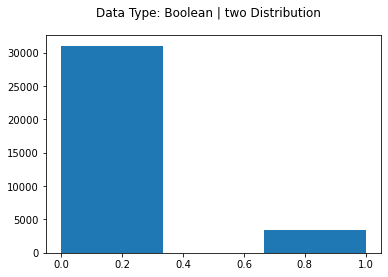

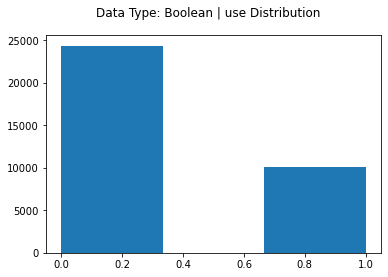

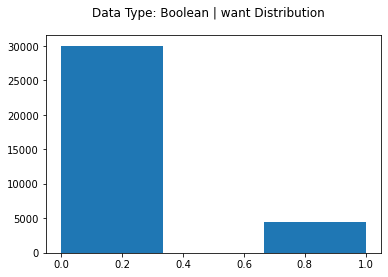

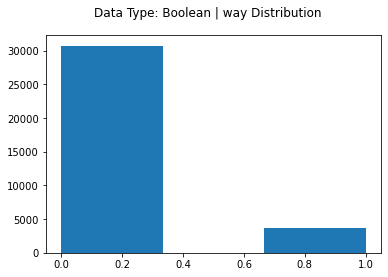

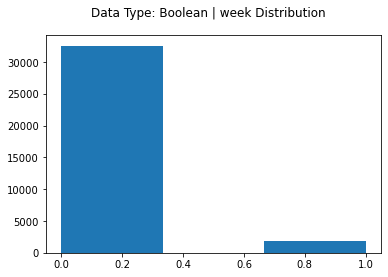

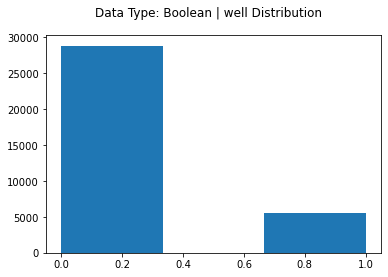

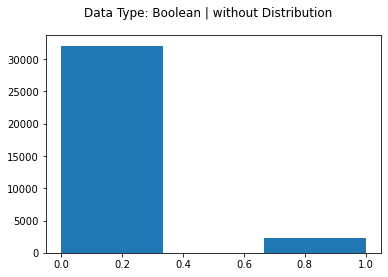

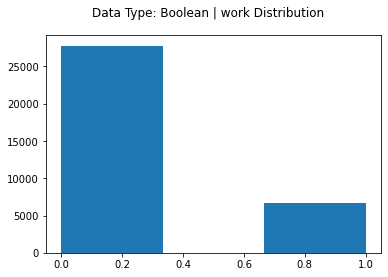

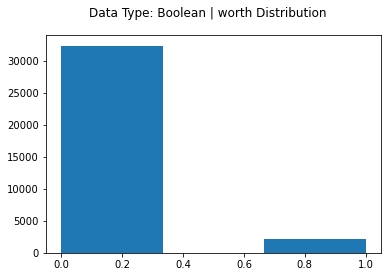

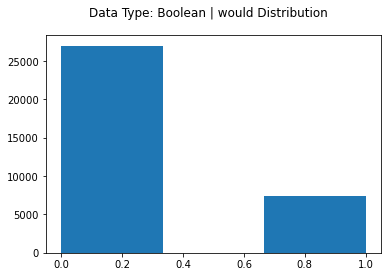

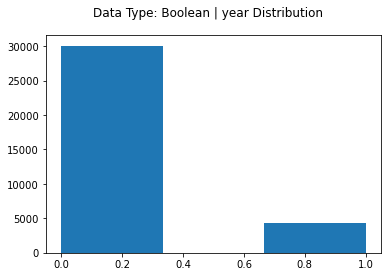

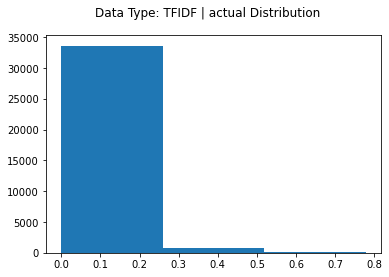

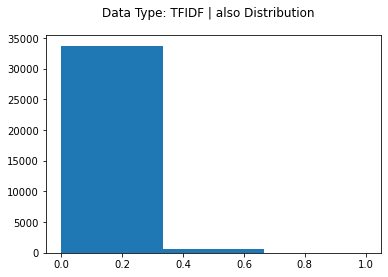

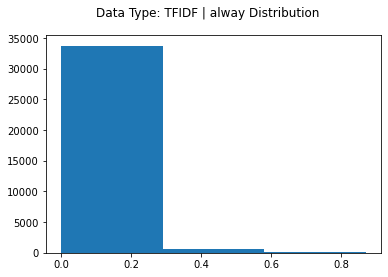

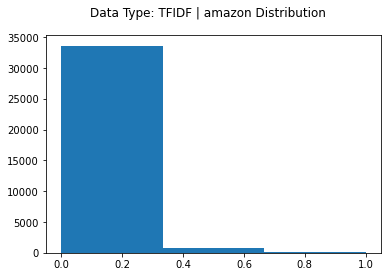

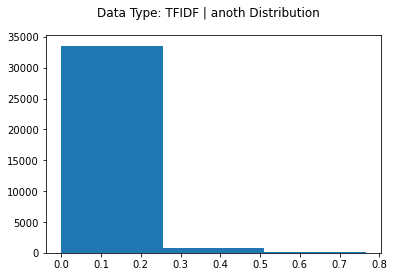

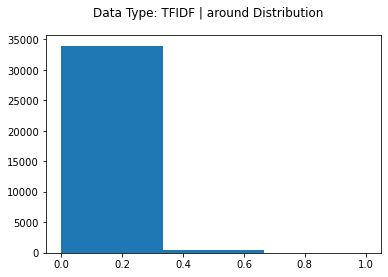

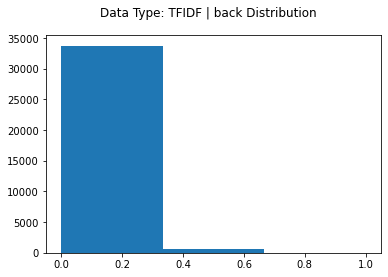

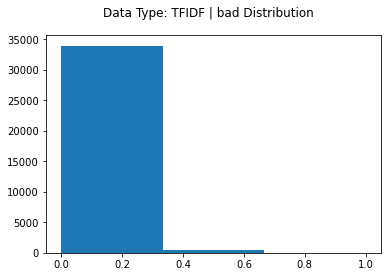

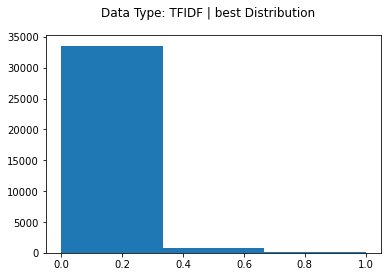

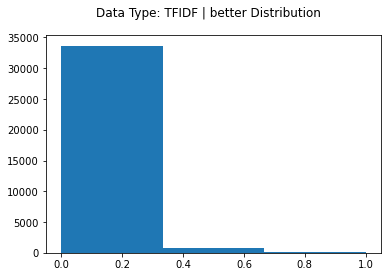

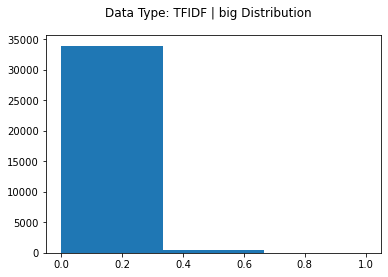

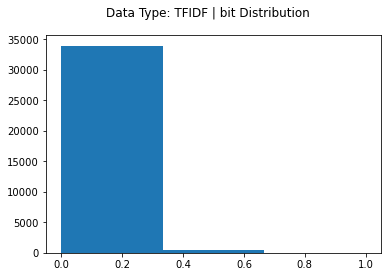

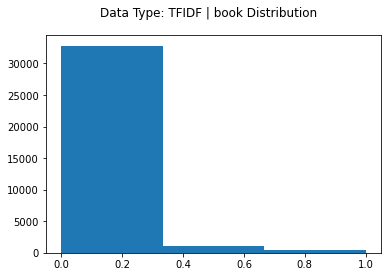

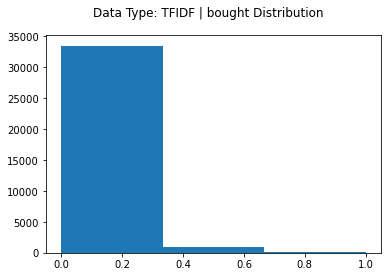

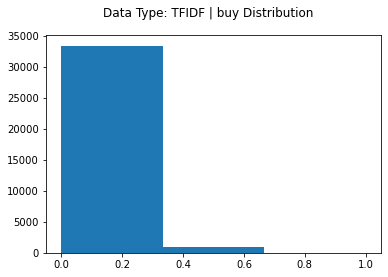

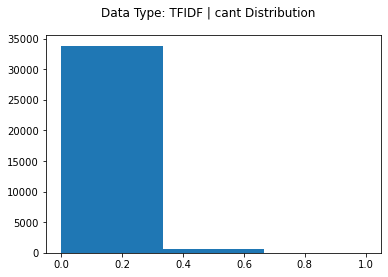

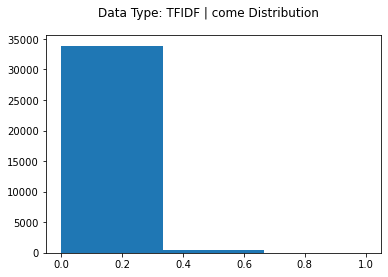

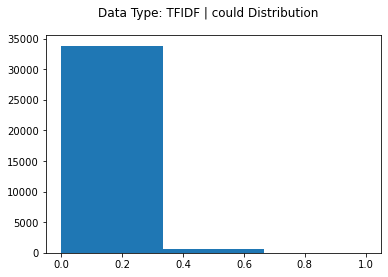

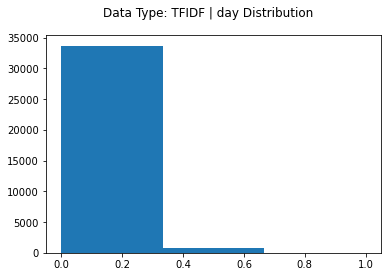

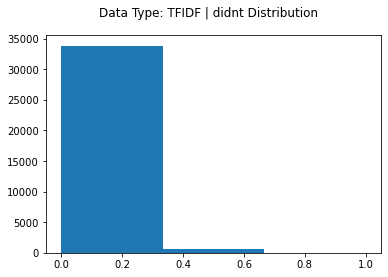

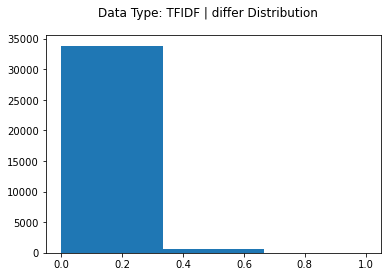

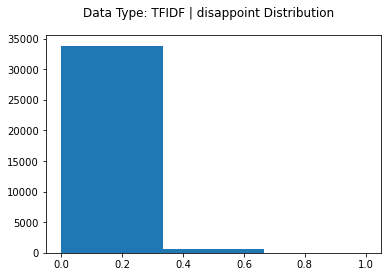

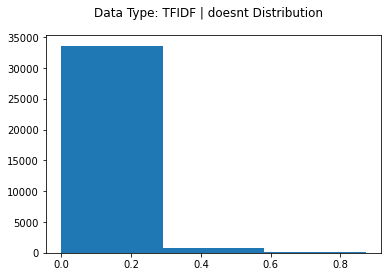

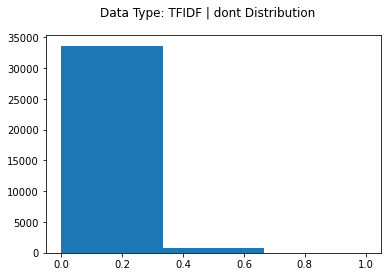

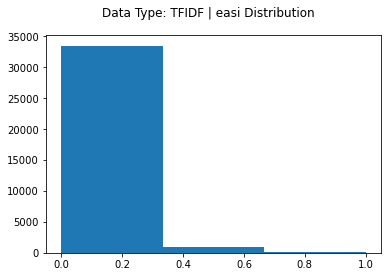

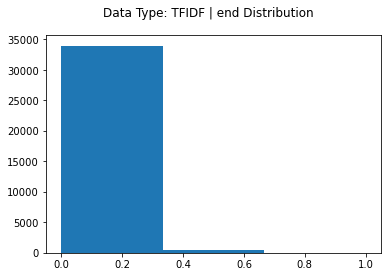

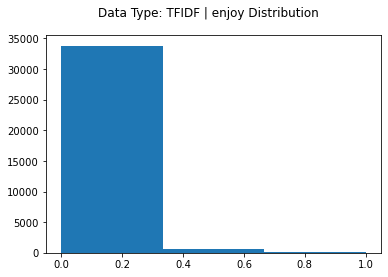

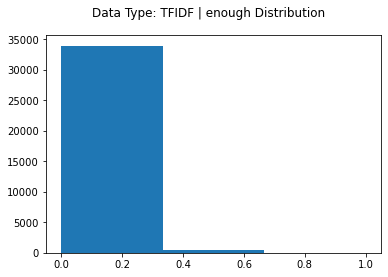

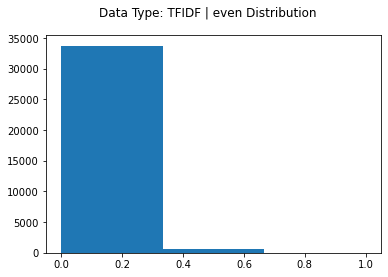

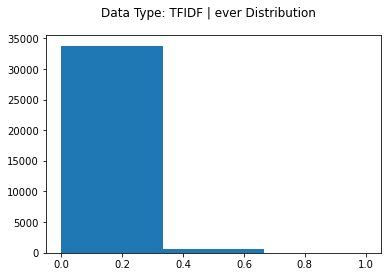

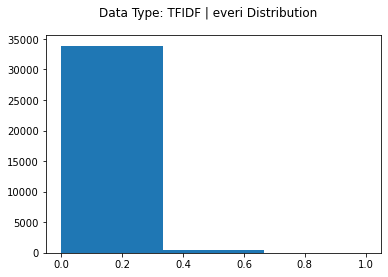

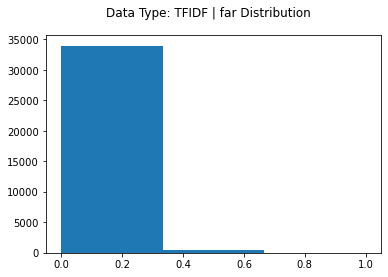

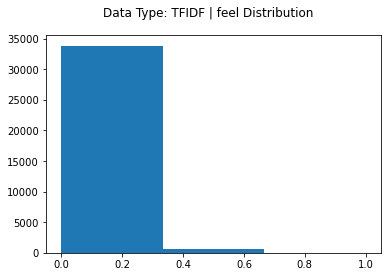

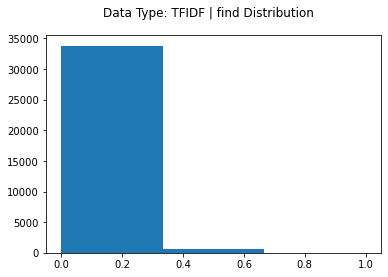

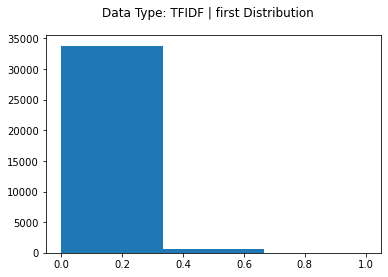

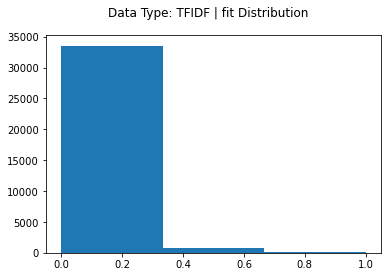

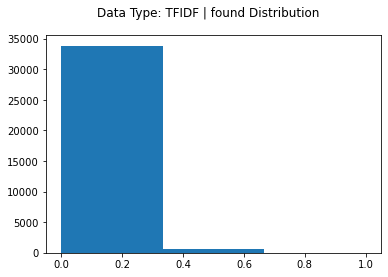

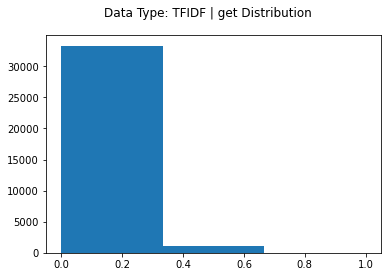

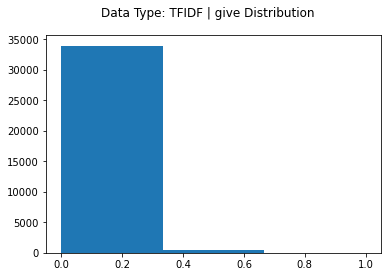

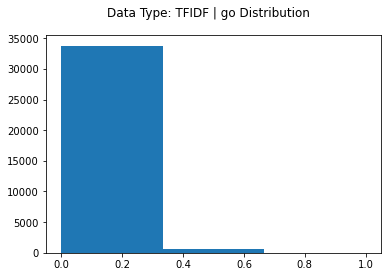

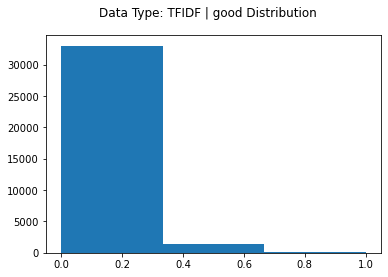

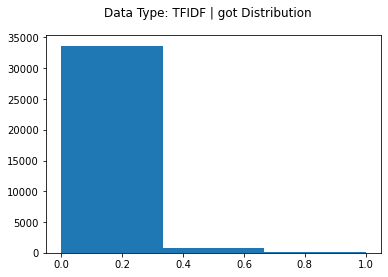

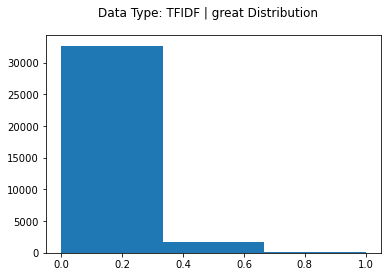

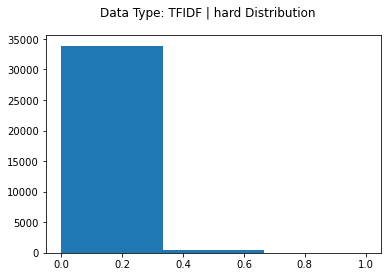

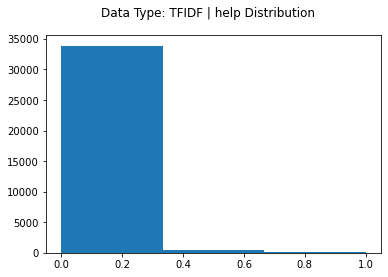

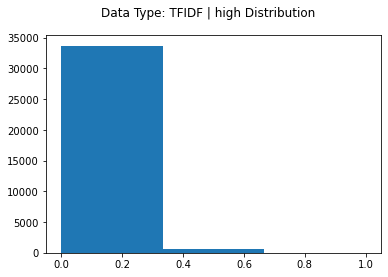

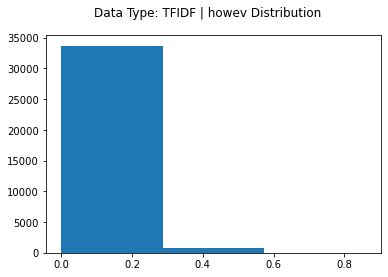

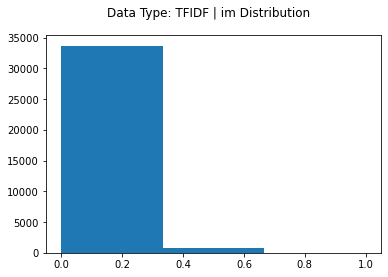

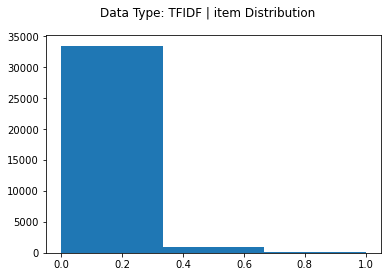

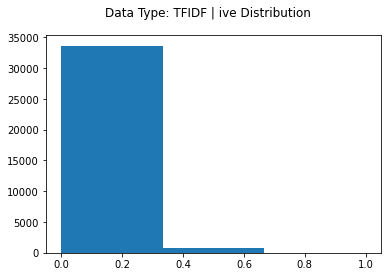

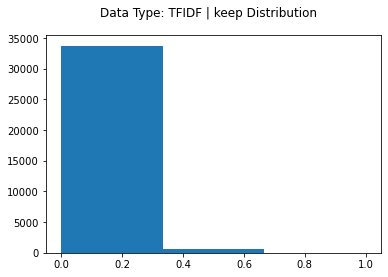

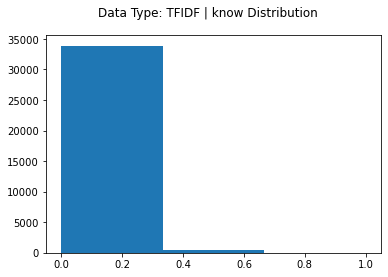

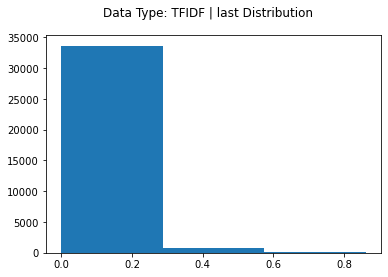

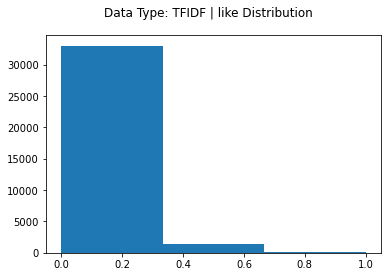

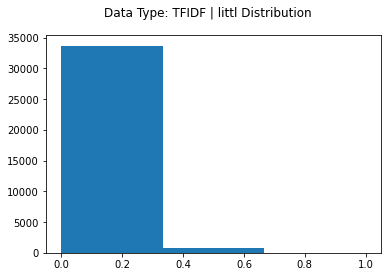

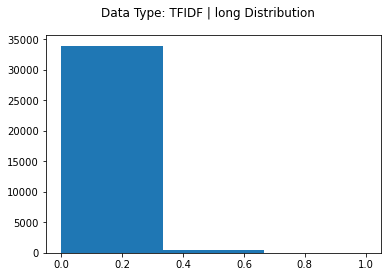

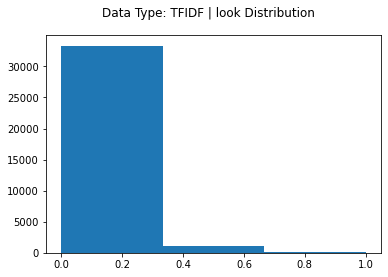

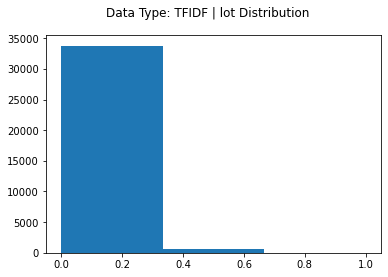

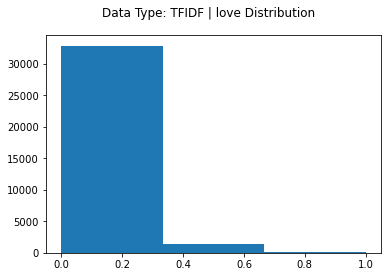

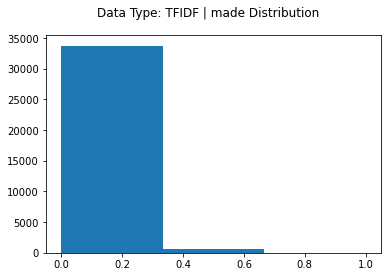

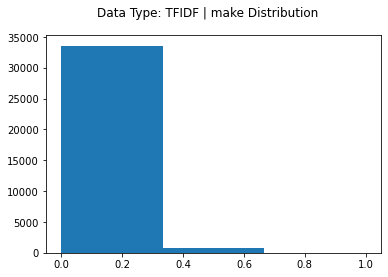

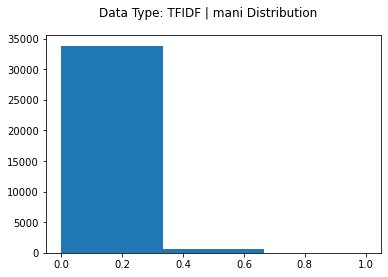

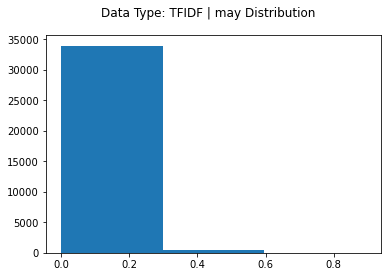

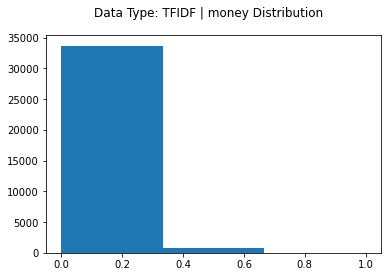

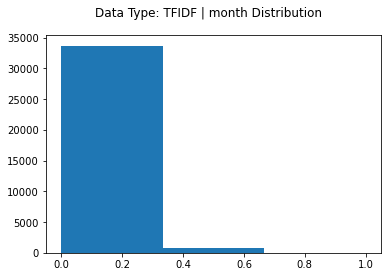

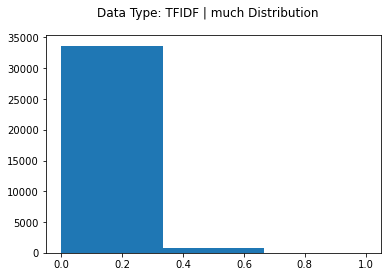

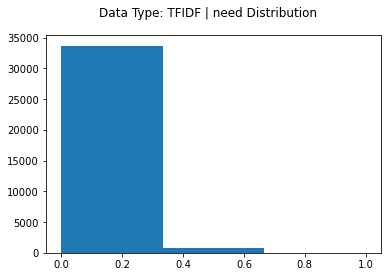

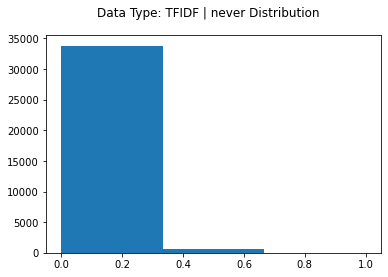

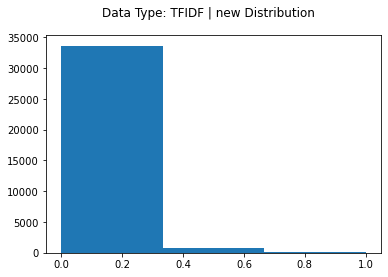

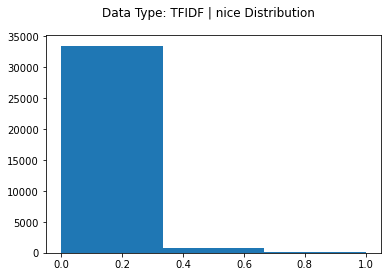

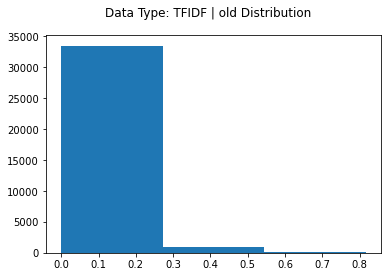

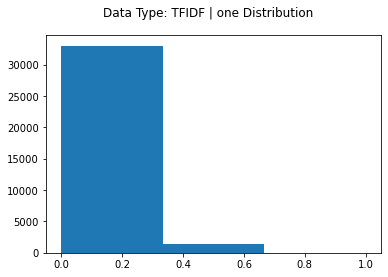

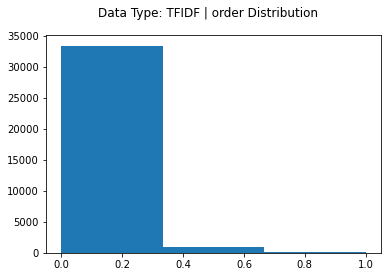

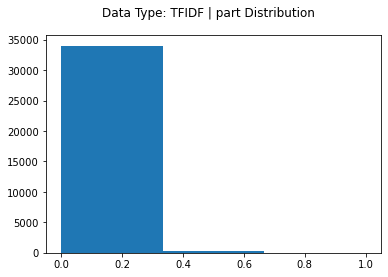

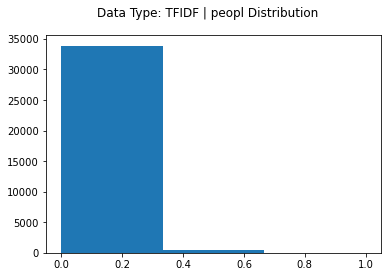

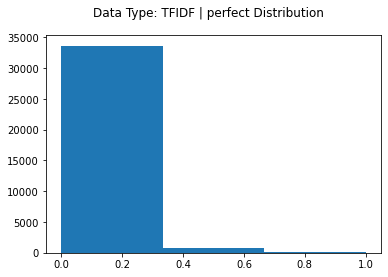

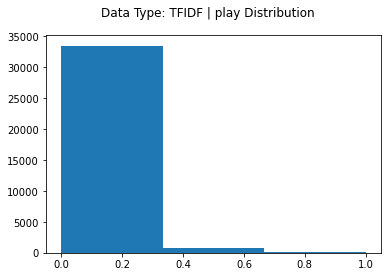

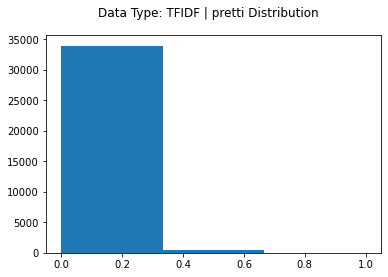

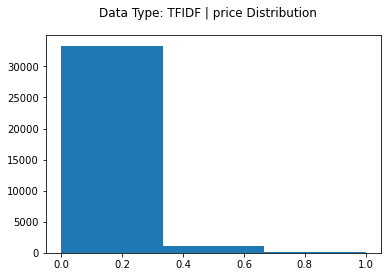

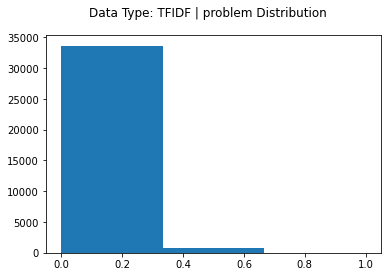

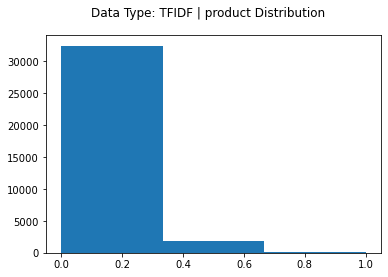

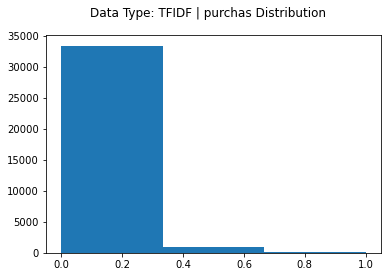

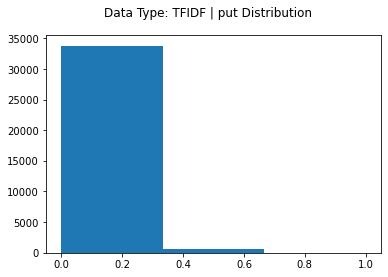

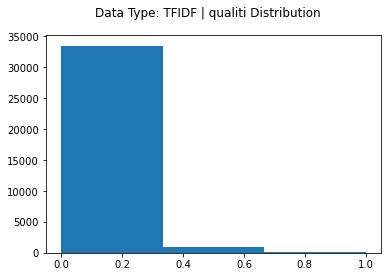

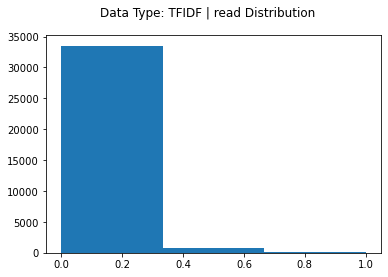

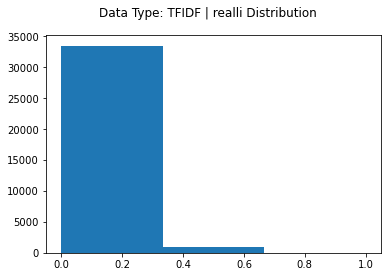

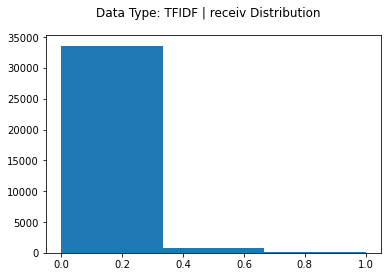

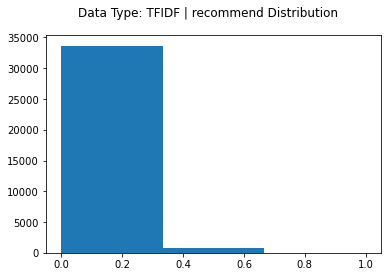

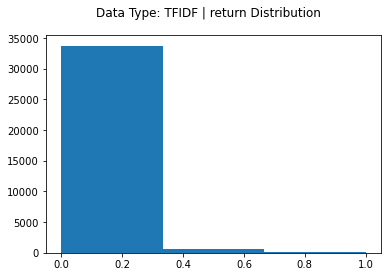

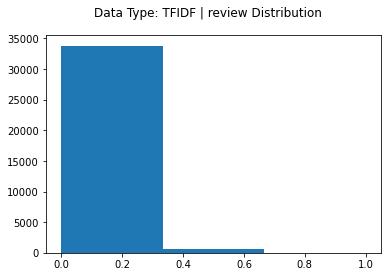

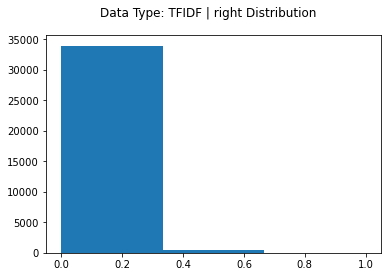

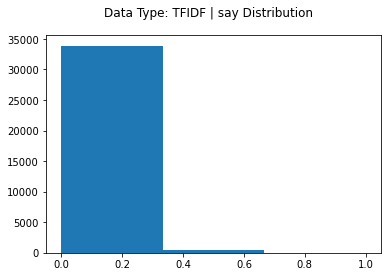

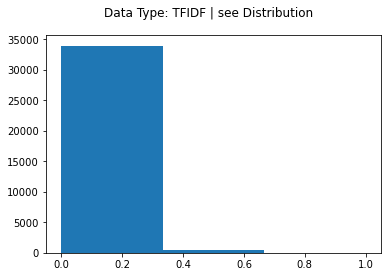

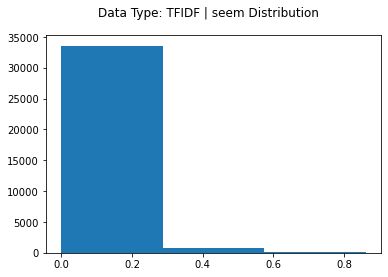

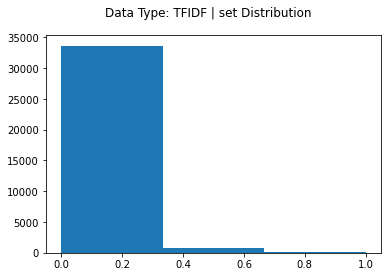

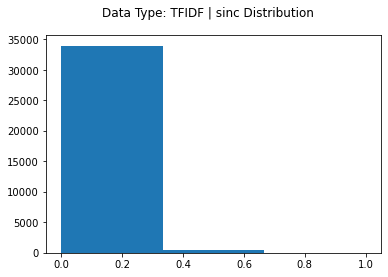

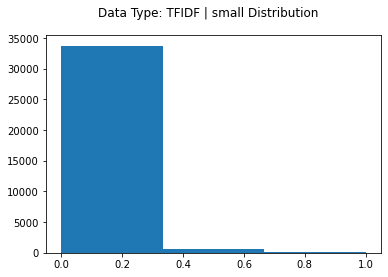

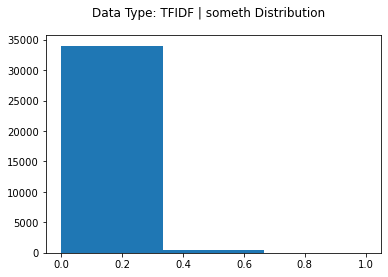

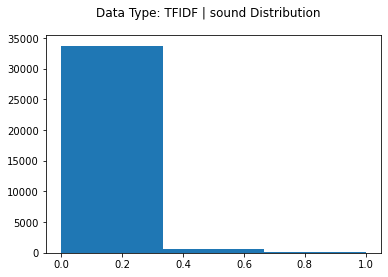

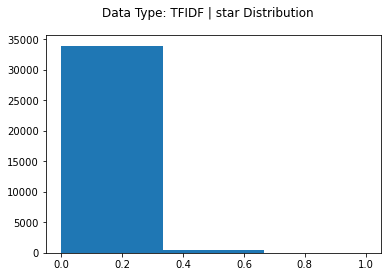

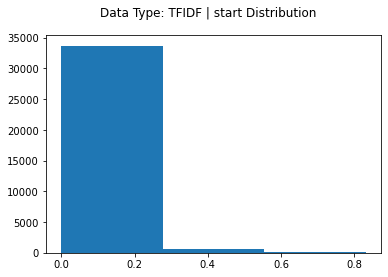

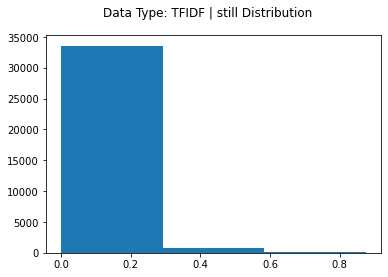

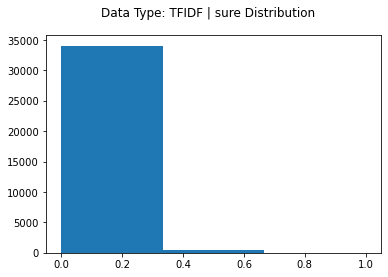

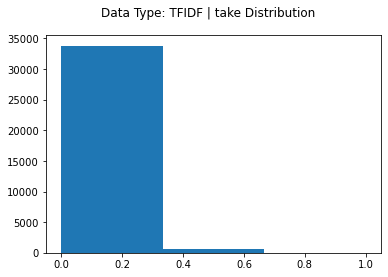

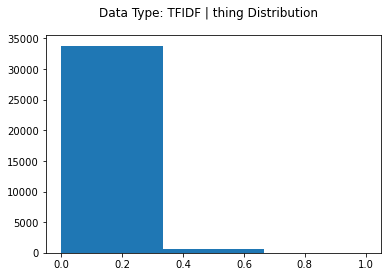

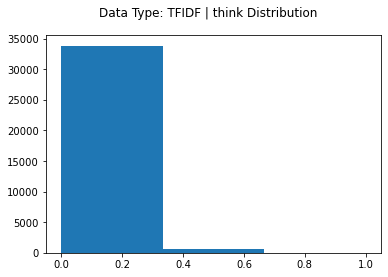

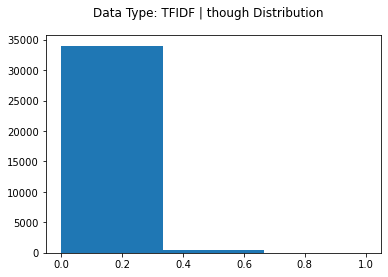

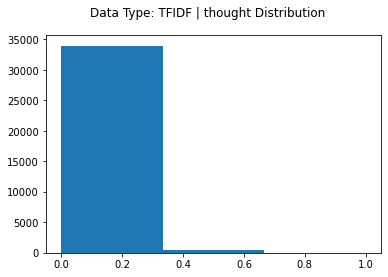

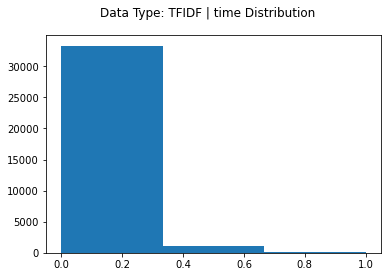

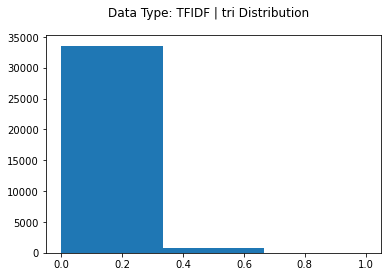

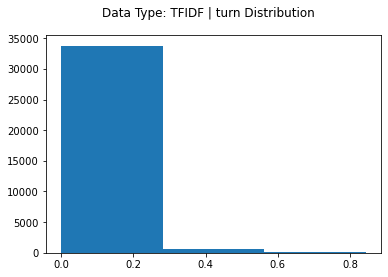

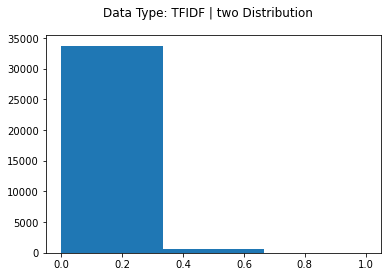

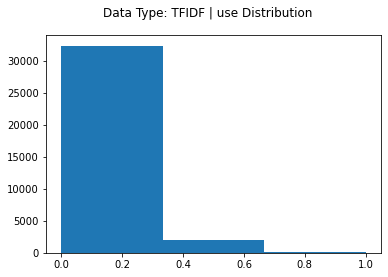

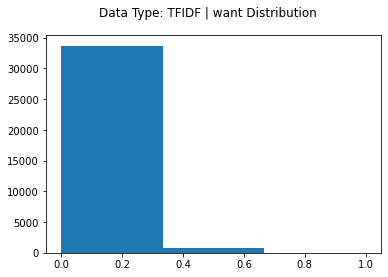

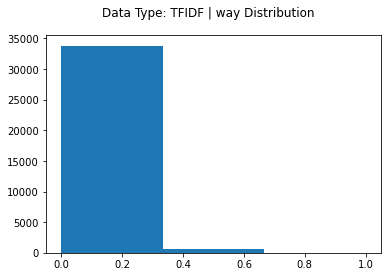

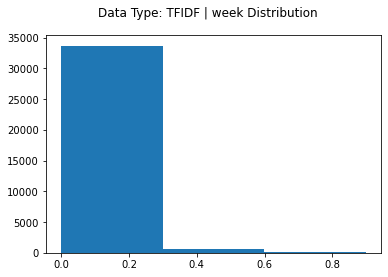

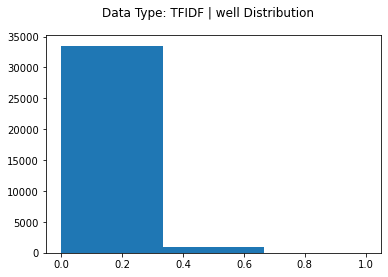

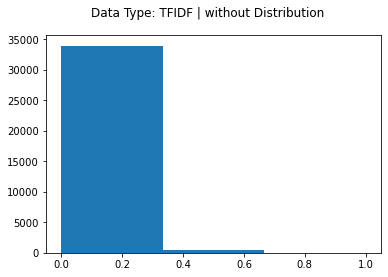

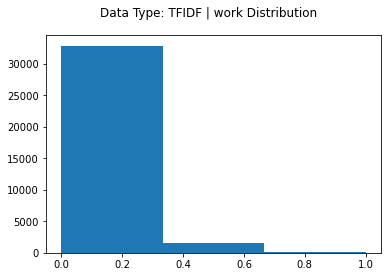

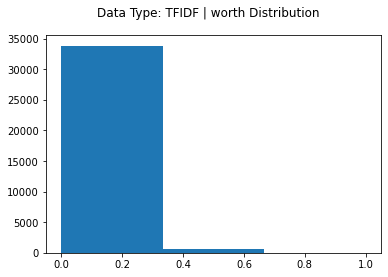

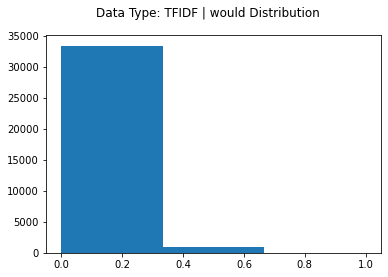

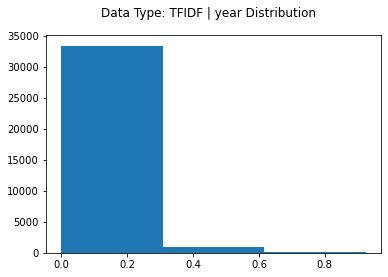

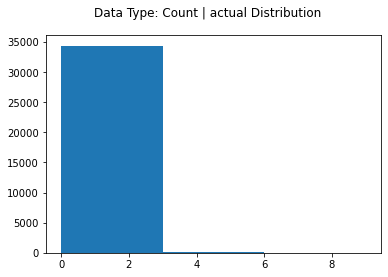

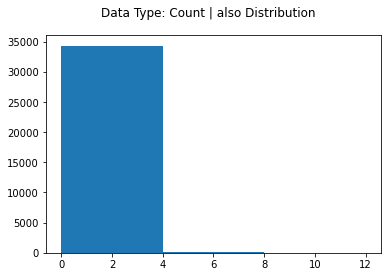

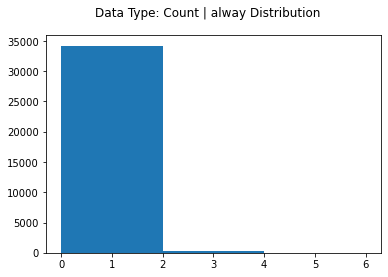

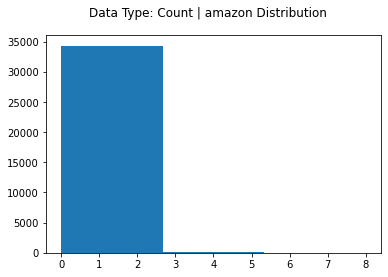

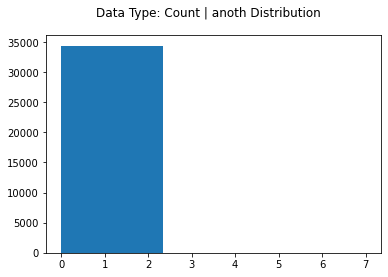

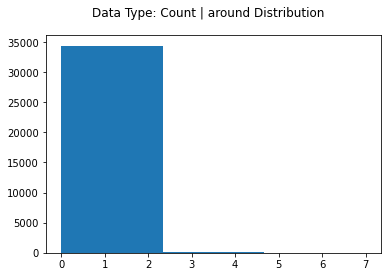

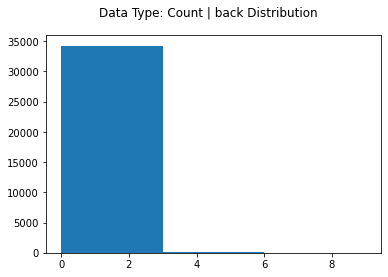

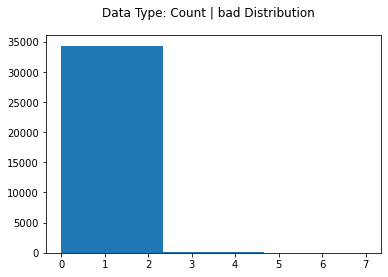

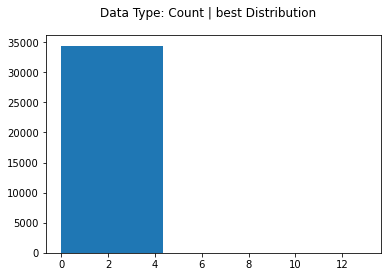

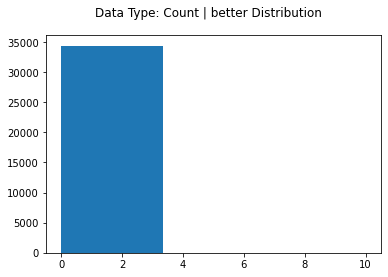

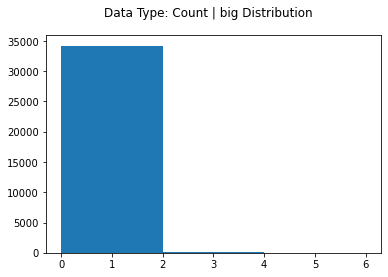

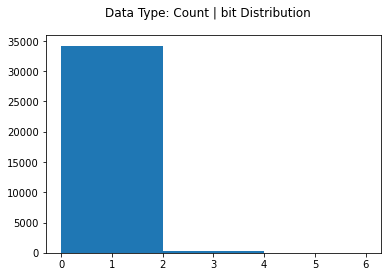

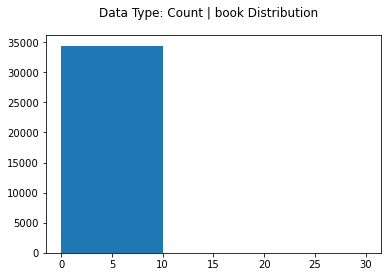

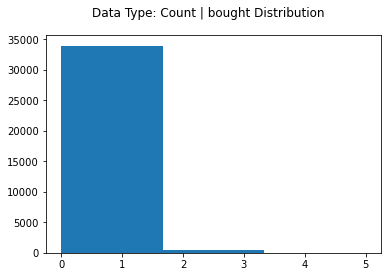

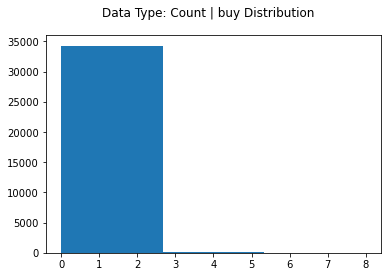

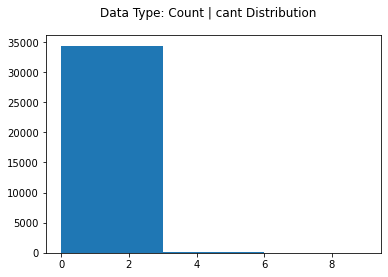

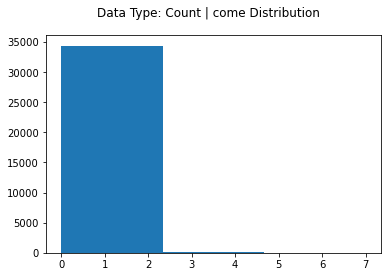

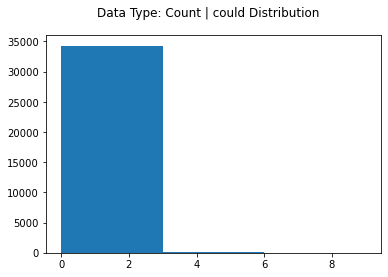

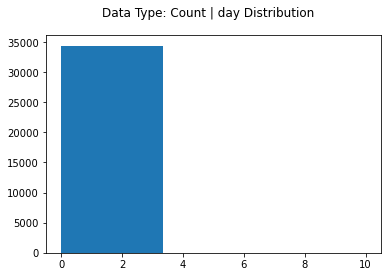

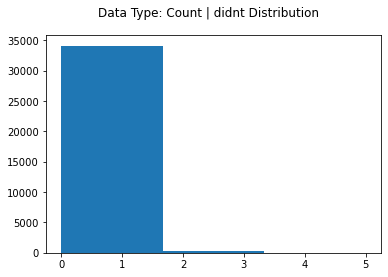

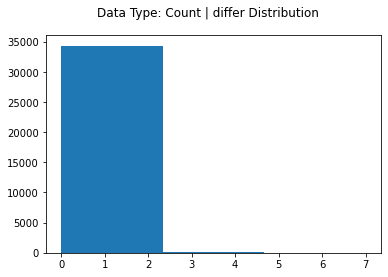

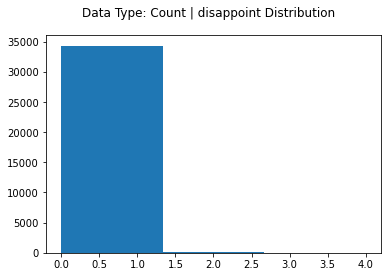

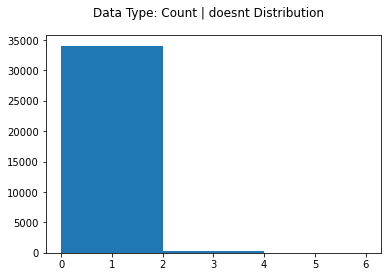

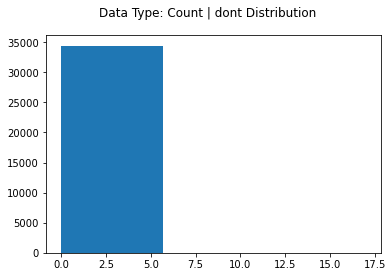

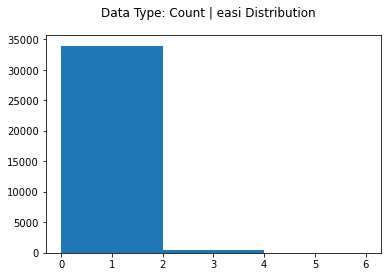

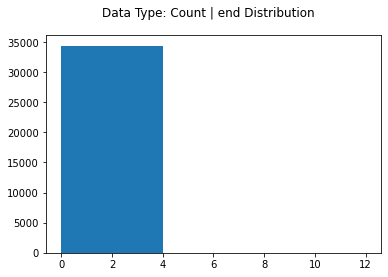

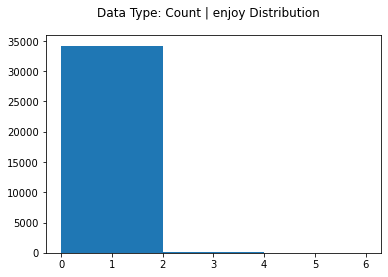

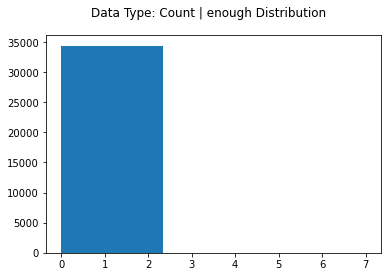

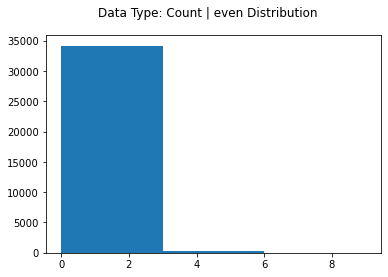

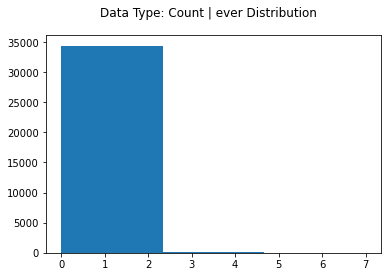

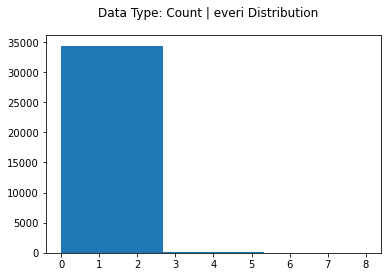

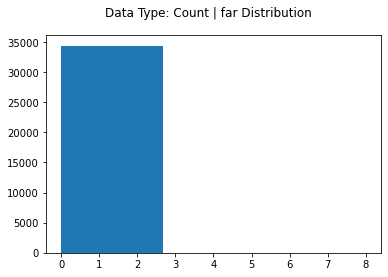

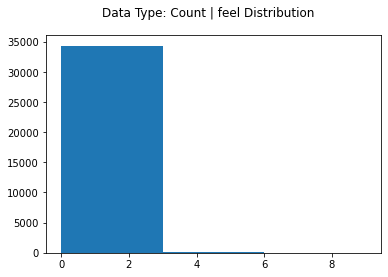

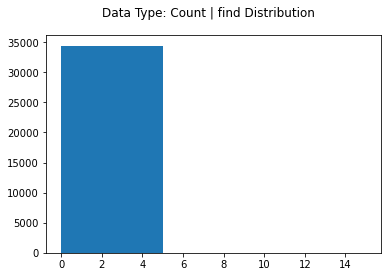

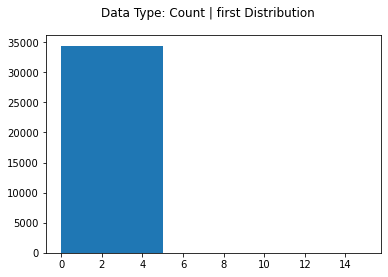

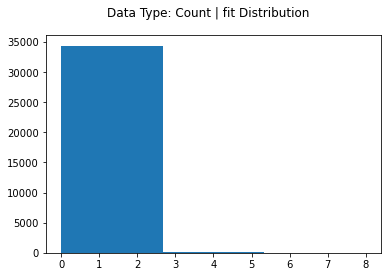

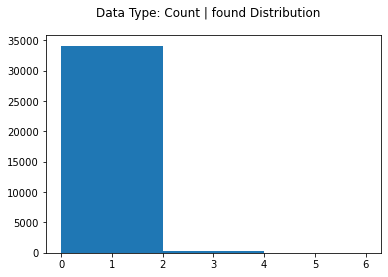

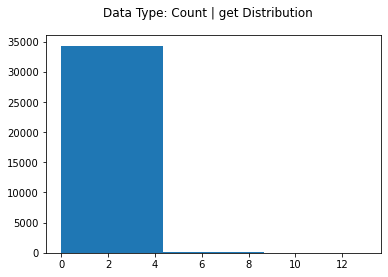

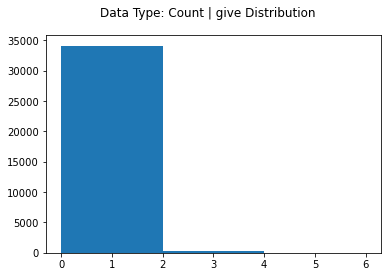

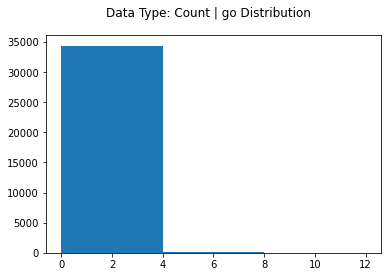

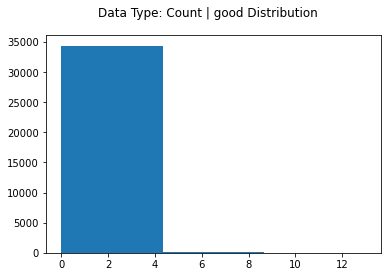

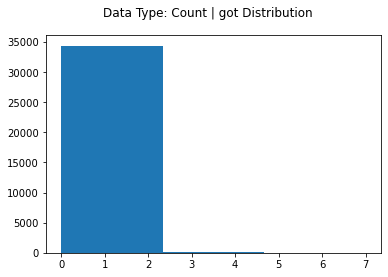

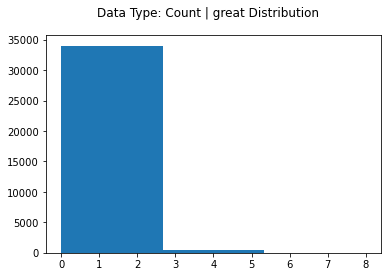

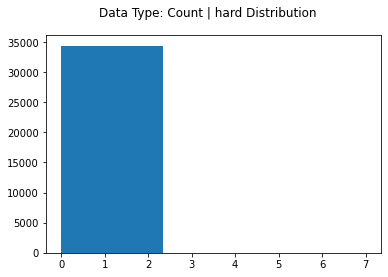

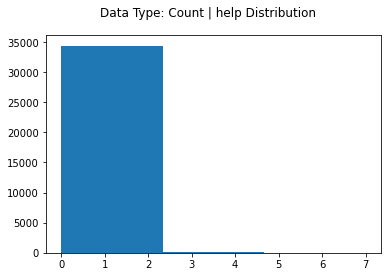

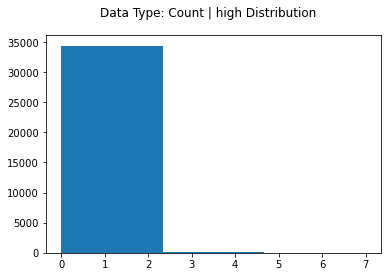

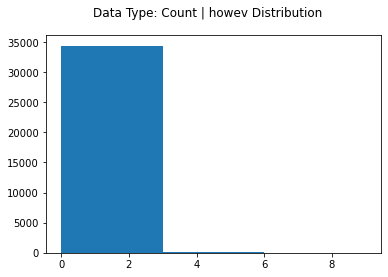

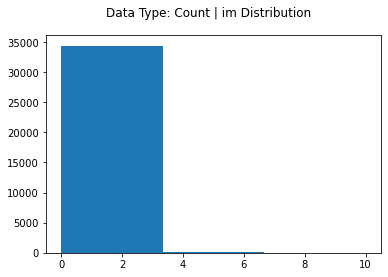

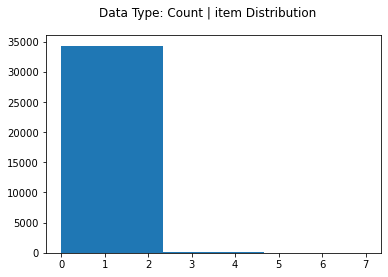

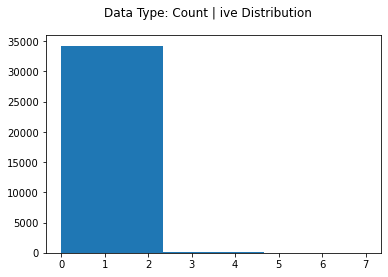

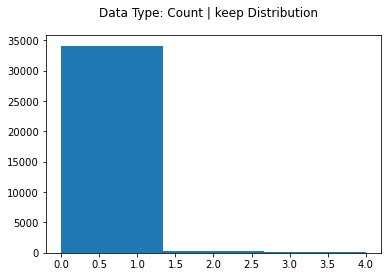

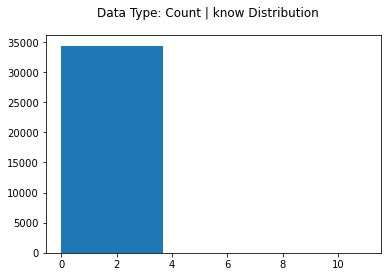

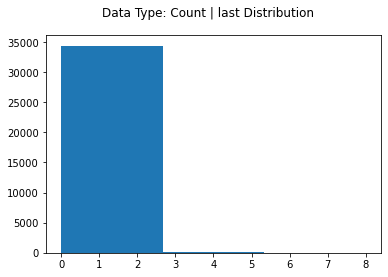

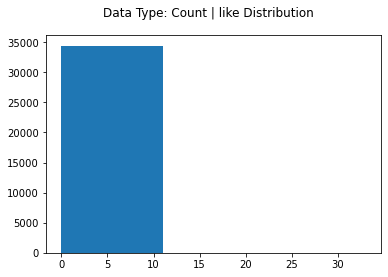

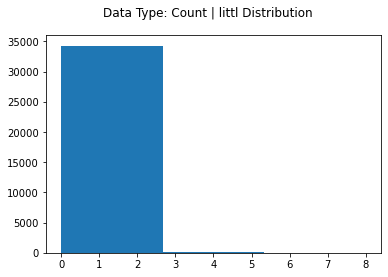

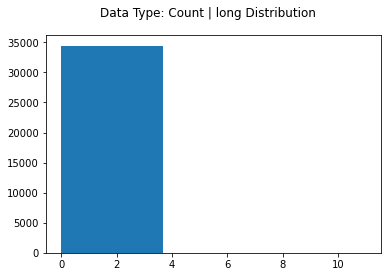

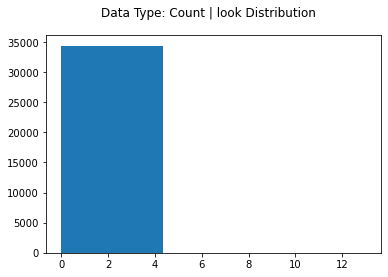

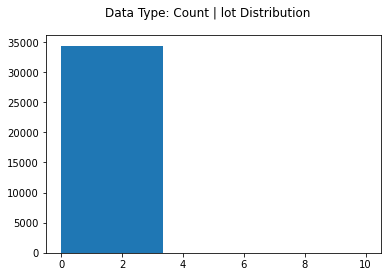

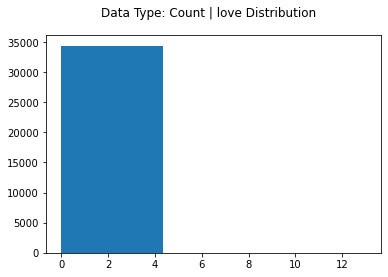

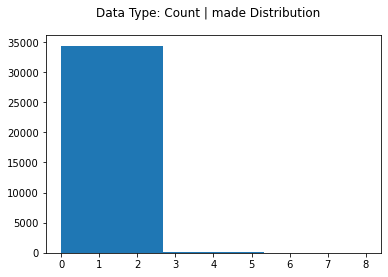

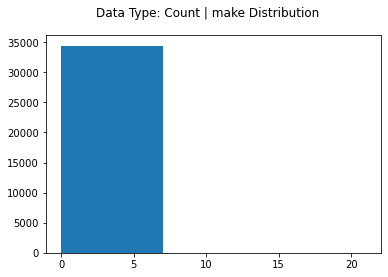

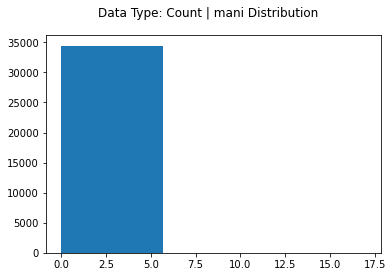

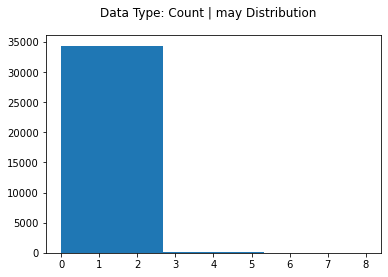

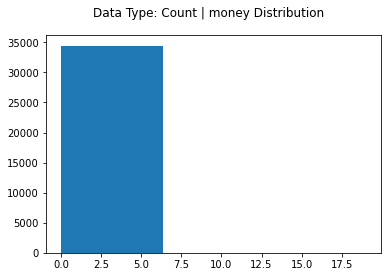

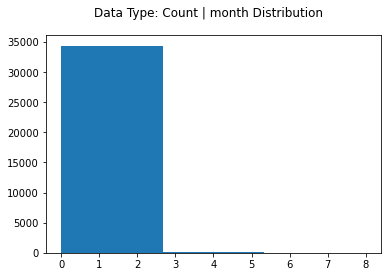

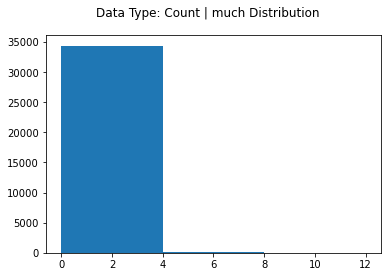

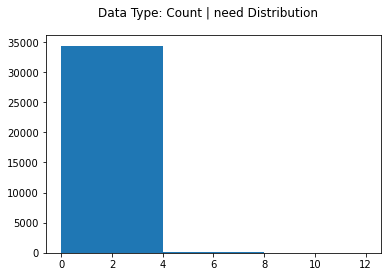

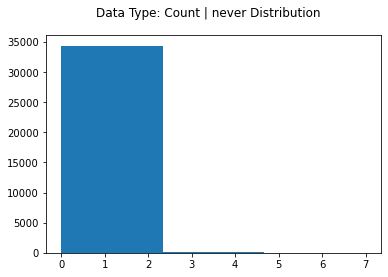

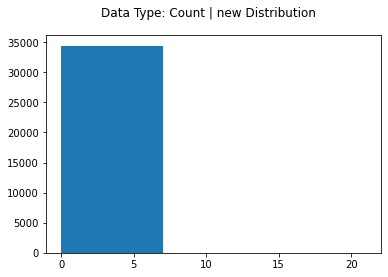

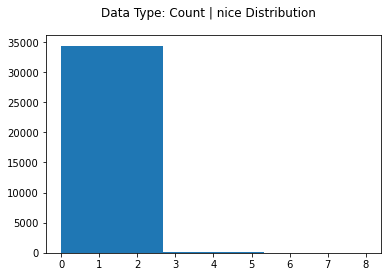

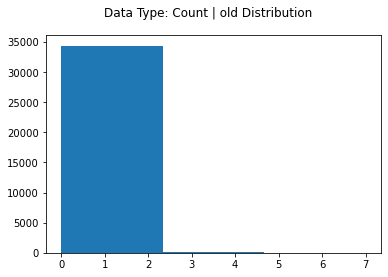

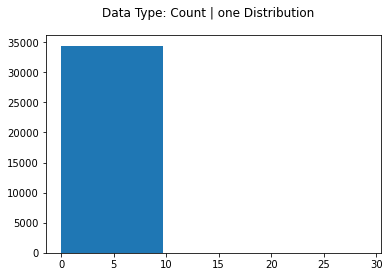

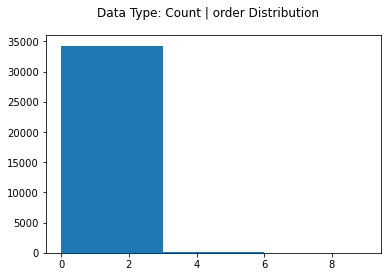

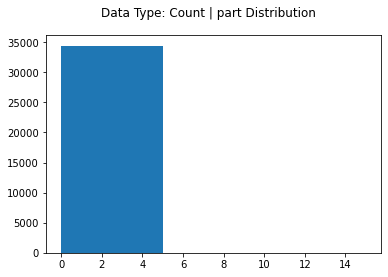

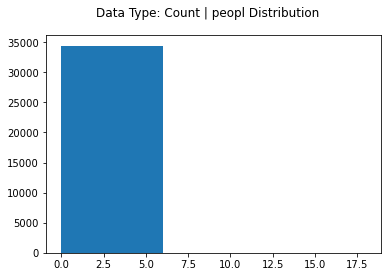

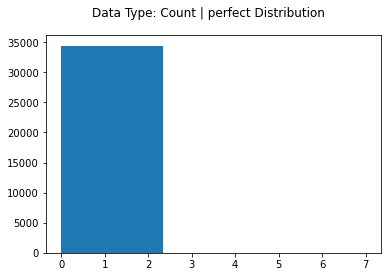

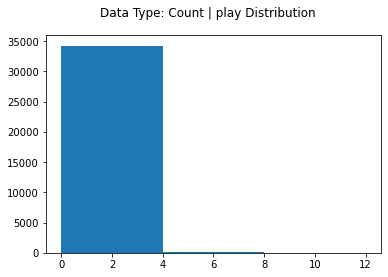

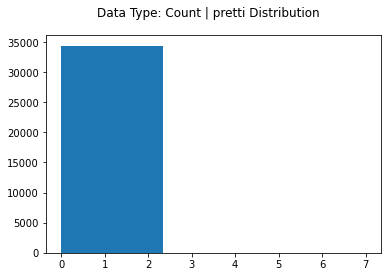

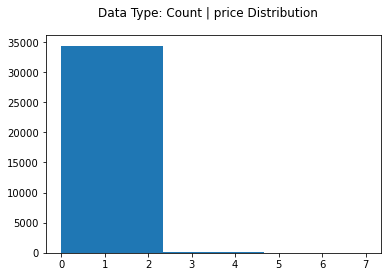

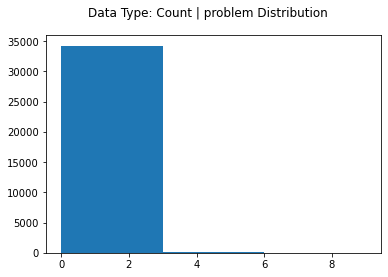

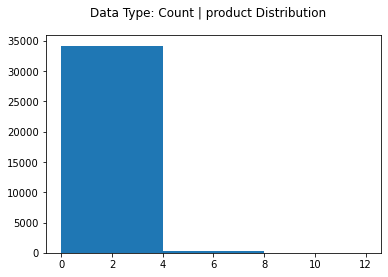

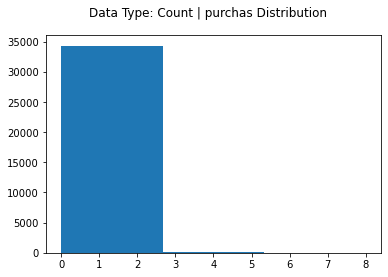

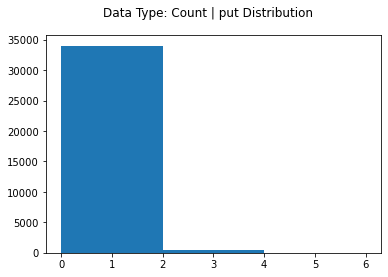

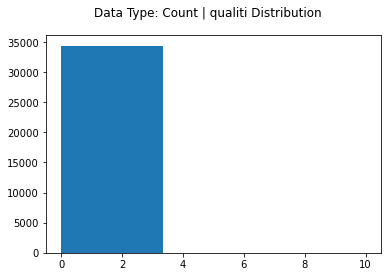

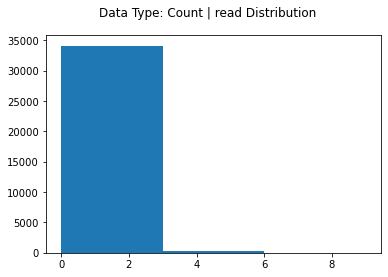

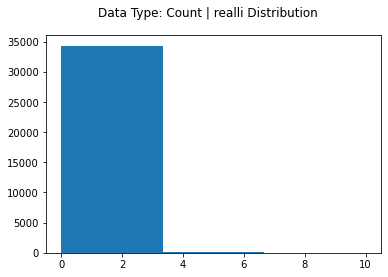

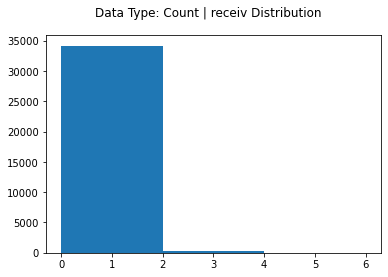

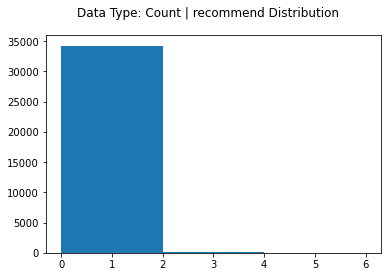

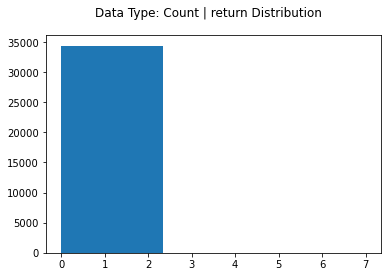

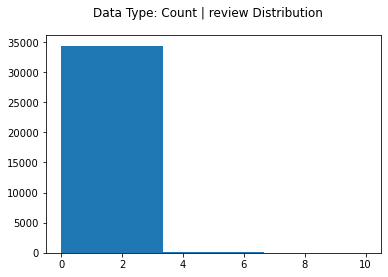

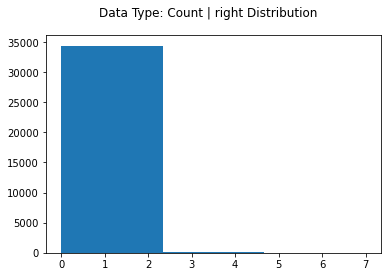

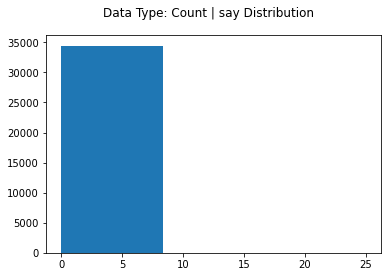

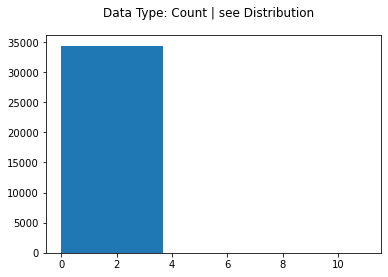

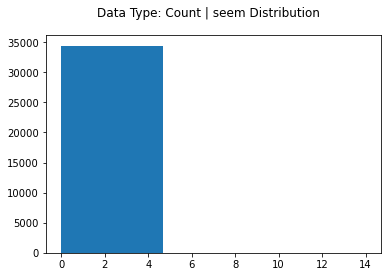

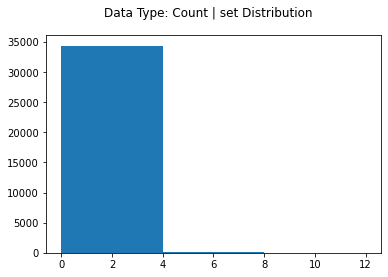

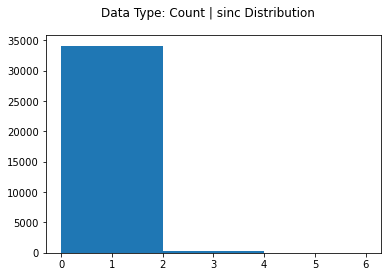

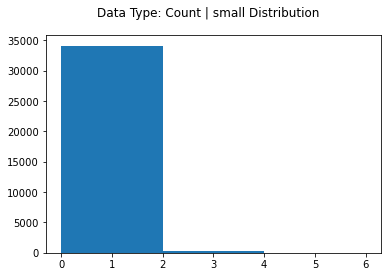

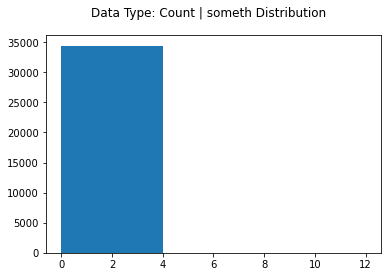

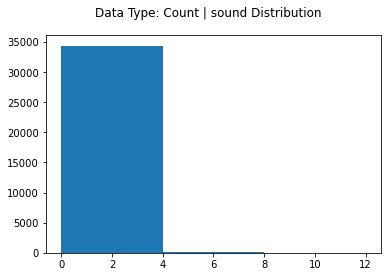

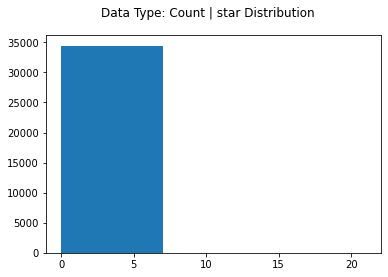

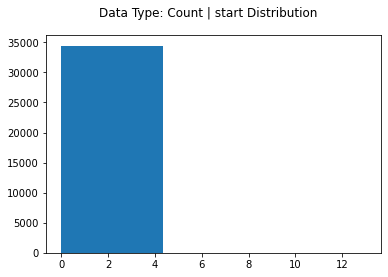

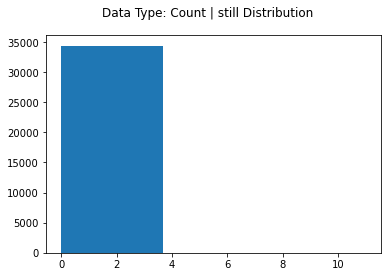

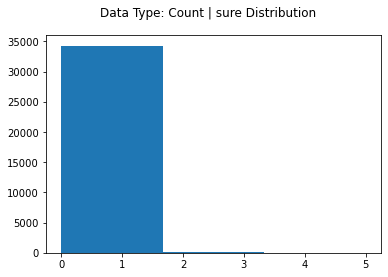

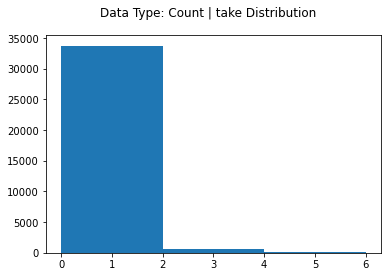

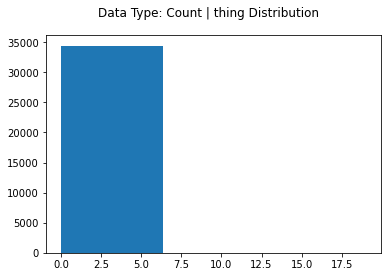

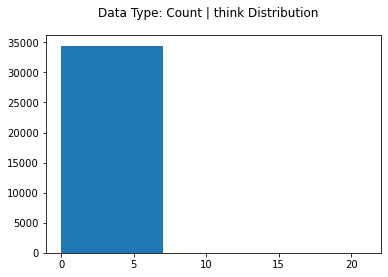

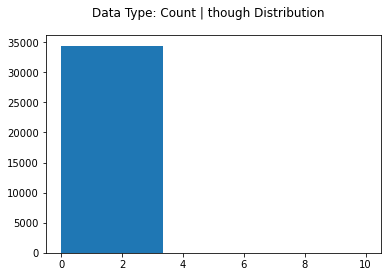

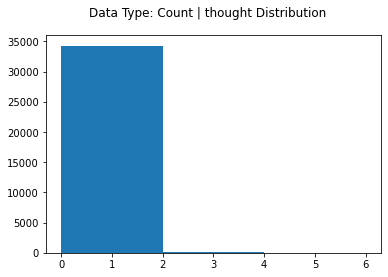

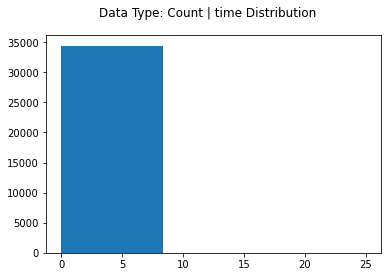

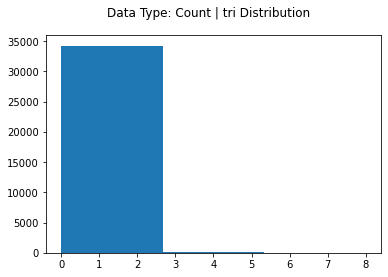

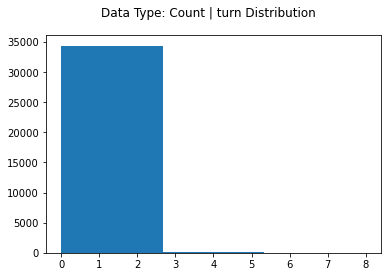

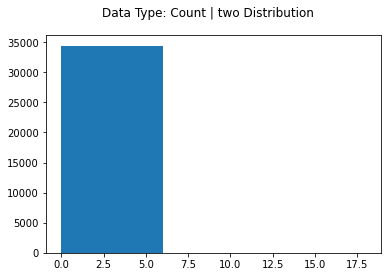

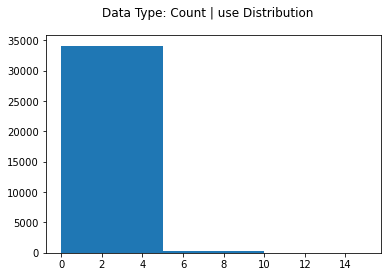

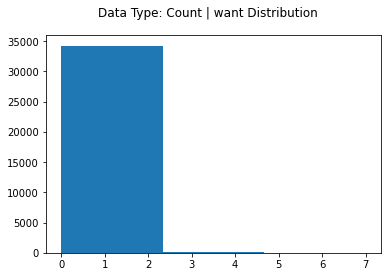

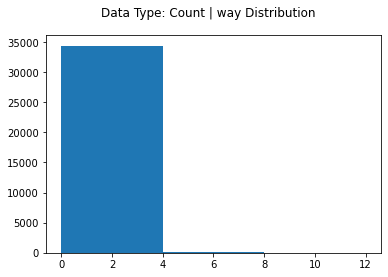

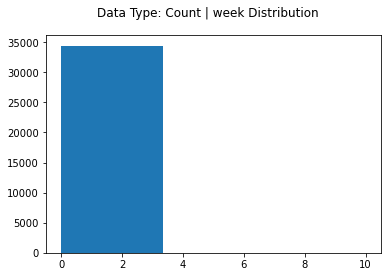

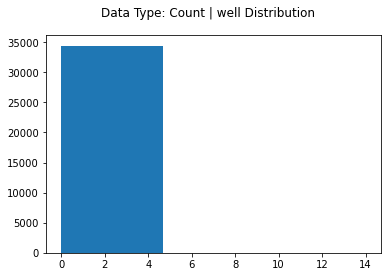

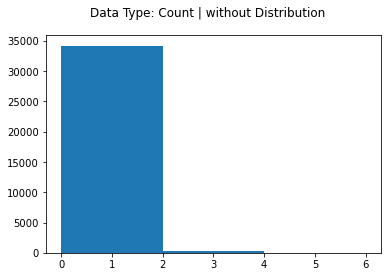

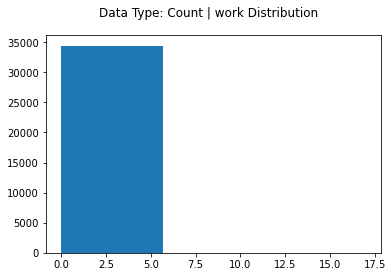

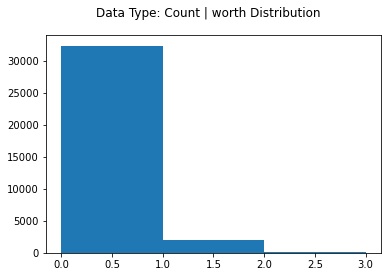

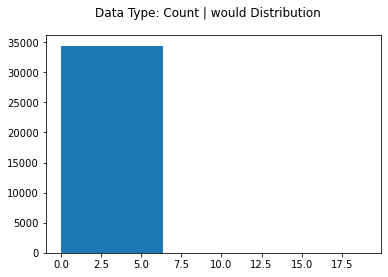

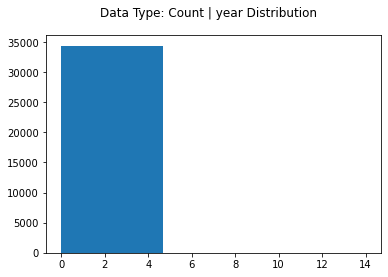

In [18]:
# Get some quick plots to show the distributions of each word in each dataset
for i in range(len(dfs)):
    plot_df_distributions(dfs[i], names[i])

In [21]:
sims = 10
folds = 3

In [22]:
# Test some basic classifiers

# Declare a list of classifiers to try
# classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), 
#                SVC(C=1.0, kernel='linear', degree=3, gamma='auto')]

classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB()]

# Create blank dataframes to hold the results of the classification attempts
boolean_results = pd.DataFrame(columns = ['Simulation', 'Classifier', 'Best', 'Worst', 'Average'])
tfidf_results = pd.DataFrame(columns = ['Simulation', 'Classifier', 'Best', 'Worst', 'Average'])
freq_results = pd.DataFrame(columns = ['Simulation', 'Classifier', 'Best', 'Worst', 'Average'])

# Run a given number of simulations
for n in range(sims):
    # Loop through each of the datasets
    for i in range(len(dfs)):
        print("*--------------------------------------------*")
        # Copy the dataset
        temp = dfs[i].copy()
        
        # Add the class, and shuffle it
        temp['classification'] = classes
        temp = temp.sample(frac=1).reset_index(drop=True)
        
        # Now remove the class
        temp_classes = temp['classification']
        temp.drop('classification', axis=1, inplace=True)

        # Try each classifier
        for clf in classifiers:
            # Take the classifiers name
            name = str(clf.__class__.__name__)
            try:  
                # Utilize a shuffle split for the cross validation
                cv = ShuffleSplit(n_splits = folds, test_size = 0.33, random_state=np.random.randint(1,100))
                # Capture the best, worst, and average across the splits
                best = round(max(cross_val_score(clf, temp, temp_classes, cv=cv)), 5)
                worst = round(min(cross_val_score(clf, temp, temp_classes, cv=cv)), 5)
                avg = round((sum(cross_val_score(clf, temp, temp_classes, cv=cv)) / len(cross_val_score(clf, temp, temp_classes, cv=cv))), 5)
                # Print out results
                print("Simulation: {} | Data: {} | Classifier: {} | Best: {} | Worst: {} | Average: {}".format(n+1, names[i], name, best, worst, avg))
            except:
                # Alert if any error
                print("Error Calculating: {}".format(name))

            # Create a row to append to the respective df with the results
            temp_row = [n+1, name, best, worst, avg]
            
            # Append to correct df
            if(names[i] == 'Boolean'):
                boolean_results.loc[len(boolean_results), :] = temp_row
            elif(names[i] == 'TFIDF'):
                tfidf_results.loc[len(tfidf_results), :] = temp_row
            else:
                freq_results.loc[len(freq_results), :] = temp_row
        
        # Delete temp df
        del(temp)
        
        # Free up memory
        gc.collect()

*--------------------------------------------*
Simulation: 1 | Data: Boolean | Classifier: GaussianNB | Best: 0.50202 | Worst: 0.4919 | Average: 0.4973
Simulation: 1 | Data: Boolean | Classifier: MultinomialNB | Best: 0.54356 | Worst: 0.54189 | Average: 0.5425
Simulation: 1 | Data: Boolean | Classifier: BernoulliNB | Best: 0.52006 | Worst: 0.50678 | Average: 0.51223
*--------------------------------------------*
Simulation: 1 | Data: TFIDF | Classifier: GaussianNB | Best: 0.49067 | Worst: 0.48469 | Average: 0.4885
Simulation: 1 | Data: TFIDF | Classifier: MultinomialNB | Best: 0.52666 | Worst: 0.52033 | Average: 0.52417
Simulation: 1 | Data: TFIDF | Classifier: BernoulliNB | Best: 0.52191 | Worst: 0.50502 | Average: 0.51472
*--------------------------------------------*
Simulation: 1 | Data: Count | Classifier: GaussianNB | Best: 0.49375 | Worst: 0.48733 | Average: 0.48991
Simulation: 1 | Data: Count | Classifier: MultinomialNB | Best: 0.55315 | Worst: 0.54074 | Average: 0.54811
Simula

Simulation: 8 | Data: TFIDF | Classifier: MultinomialNB | Best: 0.52746 | Worst: 0.51522 | Average: 0.5225
Simulation: 8 | Data: TFIDF | Classifier: BernoulliNB | Best: 0.51857 | Worst: 0.5037 | Average: 0.51223
*--------------------------------------------*
Simulation: 8 | Data: Count | Classifier: GaussianNB | Best: 0.48794 | Worst: 0.47791 | Average: 0.48278
Simulation: 8 | Data: Count | Classifier: MultinomialNB | Best: 0.5491 | Worst: 0.54752 | Average: 0.54822
Simulation: 8 | Data: Count | Classifier: BernoulliNB | Best: 0.51778 | Worst: 0.50836 | Average: 0.51261
*--------------------------------------------*
Simulation: 9 | Data: Boolean | Classifier: GaussianNB | Best: 0.49604 | Worst: 0.4883 | Average: 0.49234
Simulation: 9 | Data: Boolean | Classifier: MultinomialNB | Best: 0.54945 | Worst: 0.54681 | Average: 0.54805
Simulation: 9 | Data: Boolean | Classifier: BernoulliNB | Best: 0.51074 | Worst: 0.50598 | Average: 0.50901
*--------------------------------------------*
Simul

In [23]:
# Store all results in one list
results = [boolean_results, tfidf_results, freq_results]   

# Plot the average across the folds for each dataset
for i in range(len(results)):
    plot_results(results[i], names[i], 'Average')

In [24]:
# In order to properly POS Tag, the raw text, and not vectorized text is needed
raw_text = total_df.copy()
# Print out the first 10 rows
print(raw_text.head(n=10))

# Free up some memory
gc.collect()

   Unnamed: 0                                               Text  Rating
0           0  GOOD LOOKING KICKS IF YOUR KICKIN IT OLD SCHOO...     4.0
1           1  These sunglasses are all right. They were a li...     4.0
2           2  I don't see the difference between these bodys...     5.0
3           3  Very nice basic clothing.  I think the size is...     5.0
4           4  I love these socks. They fit great (my 15 mont...     5.0
5           5  Finally I have found a quality brand of swimsu...     5.0
6           6  Your company was a pleasure to work with- than...     5.0
7           7  very portable. great picture. easy to operate....     5.0
8           8  I have been looking for a pair of Docs for a w...     5.0
9           9  The quality is much better than expected. I bo...     5.0


2298

In [25]:
# Declare a blank datafame
new_df = pd.DataFrame(columns = ['Nouns', 'Verbs', 'Adjectives', 'Other', 'Class'])

# Loop through the input data
for index, row in raw_text.iterrows():
    # Get the tokens according to discussed rules
    tokens = get_words(row['Text'], True)
    # Create the POS for each word
    res = nltk.pos_tag(tokens)
    # Parse the tuples, and get the counts
    nouns, adjectives, verbs, other = parse_tuples(res, False)
    # Create a temp row
    temp_row = [nouns, verbs, adjectives, other, row['Rating']]
    # Append it to the dataframe
    new_df.loc[len(new_df), :] = temp_row

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
# Plot the distribution of word types across all documents
plot_pos_distributions(new_df, ['Nouns', 'Verbs', 'Adjectives', 'Other'])

In [ ]:
# Test some basic classifiers

# Declare a list of classifiers to try
# Declare a list of classifiers to try
# classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), 
#                SVC(C=1.0, kernel='linear', degree=3, gamma='auto')]

classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB()]

# Create blank dataframes to hold the results of the classification attempts
pos_results = pd.DataFrame(columns = ['Simulation', 'Classifier', 'Best', 'Worst', 'Average'])

# Run a given number of simulations
for n in range(sims):
    print("*--------------------------------------------*")
    # Create a temp for each simulation
    temp = new_df.copy()
    # Randomly shuffle it
    temp = temp.sample(frac=1).reset_index(drop=True)
    # Try each classifier
    for clf in classifiers:
        # Take the classifiers name
        name = str(clf.__class__.__name__)
        try:  
            # Utilize a shuffle split for the cross validation
            cv = ShuffleSplit(n_splits = folds, test_size = 0.33, random_state=np.random.randint(1,100))
            # Capture the best, worst, and average across the splits
            best = round(max(cross_val_score(clf, temp, classes, cv=cv)), 5)
            worst = round(min(cross_val_score(clf, temp, classes, cv=cv)), 5)
            avg = round((sum(cross_val_score(clf, temp, classes, cv=cv)) / len(cross_val_score(clf, temp, classes, cv=cv))), 5)
            # Print out results
            print("Simulation: {} | Data: {} | Classifier: {} | Best: {} | Worst: {} | Average: {}".format(n+1, names[i], name, best, worst, avg))
        except:
            # Alert if any error
            print("Error Calculating: {}".format(name))

        # Create a row to append to the respective df with the results
        temp_row = [n+1, name, best, worst, avg]
        pos_results.loc[len(pos_results), :] = temp_row
        
        # Free up memory
        gc.collect()

In [ ]:
# Store all scaled results in one list
plot_results(pos_results, "POS Data", 'Average')